In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy
import torch
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom

In [5]:
section_config = yaml.safe_load(
    open('/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/mushroom_inputs.yaml')
)
section_config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_he.tif'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_visium.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 1},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 11},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_he.tif'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_visium.h5ad'}],
  'id': 's3',
  'position': 20},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/

## train multiplex

In [7]:
out_dir = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2'
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [8]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
# official_to_options = {
#     'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
#     'E-cadherin': ['E-cadherin'],
#     'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)'],
#     'CD45RO': ['CD45RO'],
#     'CD45RA': ['CD45RA'],
#     'CD8': ['CD8', 'CD8a'],
#     'DAPI': ['DAPI'],
#     'CD4': ['CD4', 'CD4 (D)'],
#     'CD3e': ['CD3e', 'CD3'],
#     'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
#     'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
#     'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
#     'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
#     'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
#     'CD163': ['CD163'],
#     'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
#     'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
#     'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
#     'CD36': ['CD36-(D)', 'CD36'],
#     'PR': ['PR', 'PR-(D)', 'PR (D)'],
#     'ER': ['ER', 'ER-(D)', 'ER (D)'],
#     'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
#     'P16': ['P16-(D)'],
#     'CK5': ['Keratin 5', 'KRT5'],
#     'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
#     'beta-integrin': ['beta-integrin', 'beta3-integrin'],
#     'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
#     'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
#     'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
#     'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
#     'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
#     'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
#     'COX6c': ['COX6c (D)'],
#     'Her2': ['Her2', 'Her2 (D)'],
#     'Bap1': ['Bap1 (D)'],
#     'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
#     'CD11c': ['CD11c'],
#     'HLA-DR': ['HLA-DR'],
#     'Ki67': ['Ki67', 'KI67'],
#     'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
#     'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
#     'SLC39A6': ['SLC39A6'],
#     'BCA1': ['BCA1'],
#     'BCAL': ['BCAL'],
#     'TUBB3': ['TUBB3', 'TUBB3 (D)'],
#     'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
#     'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
#     'PAI1': ['PAI1', 'PAI1-(D)'],
#     'GFAP': ['GFAP', 'GFAP (D)'],
#     'VEGFA': ['VEGFA', 'VEGFA (D)'],
#     'IBA1': ['IBA1', 'IBA1 (D)'],
#     'OLIG2': ['OLIG2', 'OLIG2 (D)'],
#     'FN1': ['FN1', 'FN1 (D)'],
#     'a-Amylase': ['a-Amylase'],
#     'Hep-Par-1': ['Hep-Par-1 (D)'],
#     'Granzyme-B': ['Granzyme B'],
#     'TCF-1': ['TCF-1'],
#     'CD39': ['CD39'],
#     'PD1': ['PD-1'],
#     'PDL1': ['PD-L1'],
#     'Histone-H3-Pho': ['Histone H3 Pho'],
#     'Maspin': ['Maspin'],
#     'MMP9': ['MMP9'],
#     'CD44': ['CD44'],
#     'CD107A': ['CD107a'],
#     'FGFR3': ['FGFR3'],
#     'CD138': ['CD138'],
#     'MLPH': ['MLPH'],
#     'P63': ['P63'],
#     'GP2': ['GP2'],
#     'COX2': ['COX2'],
#     'Lyve-1': ['Lyve-1'],
# }
# channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
channel_mapping = None

In [9]:
mushroom_config = {
    'dtype': 'multiplex',
    'sections': section_config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'triplet_scaler': 1.,
        'recon_scaler': 1.
    },
    'learner_kwargs': {
        'scale': 1.,
        'num_workers': 1,
        'channel_mapping': channel_mapping,
        'batch_size': 64
    },
    'train_kwargs': {
        'num_iters': 1000,
        'lr': 1e-4,
        'log_every': 1,
        'save_every': 100,
        'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
#         'background_channels': ['DAPI'],
        'span_all_sections': True
    }
}

In [10]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 11608 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:no background channel detected, defaulting to mean of all channels


In [11]:
mushroom.true_imgs.shape

torch.Size([2, 11608, 60, 60])

In [12]:
d = mushroom.learner.train_ds[0]
d.keys()

dict_keys(['anchor_idx', 'pos_idx', 'neg_idx', 'anchor_img', 'pos_img', 'neg_img'])

In [13]:
d['anchor_img'].shape

torch.Size([11608, 8, 8])

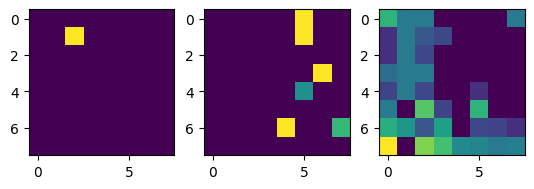

In [14]:
from einops import rearrange
fig, axs = plt.subplots(ncols=3)
idx = mushroom.learner.channels.index('EPCAM')
# idx = 0
anchor, pos, neg = d['anchor_img'][idx], d['pos_img'][idx], d['neg_img'][idx]

axs[0].imshow(anchor)
axs[1].imshow(pos)
axs[2].imshow(neg)

In [15]:
mushroom.learner.sae.to_patch

Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=1, p2=1)

In [16]:
mushroom.train()

torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 0: {'overall_loss': tensor(2.3285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.8792, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/0iter.pt


iteration 0: {'overall_loss': tensor(2.3285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.8792, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 1: {'overall_loss': tensor(2.0805, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.6559, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 1: {'overall_loss': tensor(2.0805, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.6559, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 2: {'overall_loss': tensor(1.8645, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 2: {'overall_loss': tensor(1.8645, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 3: {'overall_loss': tensor(1.7919, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2853, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 3: {'overall_loss': tensor(1.7919, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2853, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 4: {'overall_loss': tensor(1.9720, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.7138, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2582, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 4: {'overall_loss': tensor(1.9720, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.7138, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2582, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 5: {'overall_loss': tensor(2.1551, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.8651, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2900, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 5: {'overall_loss': tensor(2.1551, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.8651, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2900, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 6: {'overall_loss': tensor(1.7657, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 6: {'overall_loss': tensor(1.7657, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 7: {'overall_loss': tensor(1.6642, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4544, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2098, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 7: {'overall_loss': tensor(1.6642, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4544, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.2098, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 8: {'overall_loss': tensor(1.6157, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 8: {'overall_loss': tensor(1.6157, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 9: {'overall_loss': tensor(1.4011, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2308, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 9: {'overall_loss': tensor(1.4011, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2308, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 10: {'overall_loss': tensor(1.4473, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2966, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 10: {'overall_loss': tensor(1.4473, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2966, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 11: {'overall_loss': tensor(1.4801, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.3136, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 11: {'overall_loss': tensor(1.4801, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.3136, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 12: {'overall_loss': tensor(1.4095, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2720, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 12: {'overall_loss': tensor(1.4095, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2720, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 13: {'overall_loss': tensor(1.3947, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2659, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 13: {'overall_loss': tensor(1.3947, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2659, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 14: {'overall_loss': tensor(1.4017, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2807, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 14: {'overall_loss': tensor(1.4017, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2807, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 15: {'overall_loss': tensor(1.2878, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1792, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 15: {'overall_loss': tensor(1.2878, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1792, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 16: {'overall_loss': tensor(1.2534, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1216, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 16: {'overall_loss': tensor(1.2534, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1216, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 17: {'overall_loss': tensor(1.0773, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9642, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 17: {'overall_loss': tensor(1.0773, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9642, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 18: {'overall_loss': tensor(1.4240, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.3079, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 18: {'overall_loss': tensor(1.4240, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.3079, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 19: {'overall_loss': tensor(1.2310, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1098, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 19: {'overall_loss': tensor(1.2310, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1098, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 20: {'overall_loss': tensor(1.1250, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0405, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 20: {'overall_loss': tensor(1.1250, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0405, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 21: {'overall_loss': tensor(1.3626, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2563, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 21: {'overall_loss': tensor(1.3626, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2563, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 22: {'overall_loss': tensor(1.1940, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0822, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 22: {'overall_loss': tensor(1.1940, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0822, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 23: {'overall_loss': tensor(1.0032, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9182, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 23: {'overall_loss': tensor(1.0032, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9182, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 24: {'overall_loss': tensor(1.2734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 24: {'overall_loss': tensor(1.2734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 25: {'overall_loss': tensor(1.1697, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0664, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 25: {'overall_loss': tensor(1.1697, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0664, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 26: {'overall_loss': tensor(1.0352, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9677, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 26: {'overall_loss': tensor(1.0352, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9677, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 27: {'overall_loss': tensor(1.4849, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4077, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 27: {'overall_loss': tensor(1.4849, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4077, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 28: {'overall_loss': tensor(1.1876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1019, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 28: {'overall_loss': tensor(1.1876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1019, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 29: {'overall_loss': tensor(1.1469, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0609, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 29: {'overall_loss': tensor(1.1469, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0609, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 30: {'overall_loss': tensor(1.2534, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1581, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 30: {'overall_loss': tensor(1.2534, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1581, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 31: {'overall_loss': tensor(1.1275, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0351, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 31: {'overall_loss': tensor(1.1275, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0351, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 32: {'overall_loss': tensor(1.0791, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9720, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 32: {'overall_loss': tensor(1.0791, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9720, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 33: {'overall_loss': tensor(1.0097, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9241, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 33: {'overall_loss': tensor(1.0097, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9241, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 34: {'overall_loss': tensor(1.1563, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0680, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 34: {'overall_loss': tensor(1.1563, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0680, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 35: {'overall_loss': tensor(1.1434, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0593, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 35: {'overall_loss': tensor(1.1434, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0593, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 36: {'overall_loss': tensor(1.0537, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9844, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 36: {'overall_loss': tensor(1.0537, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9844, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 37: {'overall_loss': tensor(0.9368, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8458, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 37: {'overall_loss': tensor(0.9368, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8458, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 38: {'overall_loss': tensor(1.1240, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0491, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 38: {'overall_loss': tensor(1.1240, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0491, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 39: {'overall_loss': tensor(1.0516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9619, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 39: {'overall_loss': tensor(1.0516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9619, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 40: {'overall_loss': tensor(1.0393, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9687, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 40: {'overall_loss': tensor(1.0393, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9687, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 41: {'overall_loss': tensor(1.0724, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9960, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 41: {'overall_loss': tensor(1.0724, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9960, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 42: {'overall_loss': tensor(1.0868, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9983, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 42: {'overall_loss': tensor(1.0868, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9983, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 43: {'overall_loss': tensor(0.9185, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8082, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 43: {'overall_loss': tensor(0.9185, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8082, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 44: {'overall_loss': tensor(1.0018, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9416, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 44: {'overall_loss': tensor(1.0018, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9416, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 45: {'overall_loss': tensor(1.0514, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9526, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 45: {'overall_loss': tensor(1.0514, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9526, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 46: {'overall_loss': tensor(1.1159, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0369, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 46: {'overall_loss': tensor(1.1159, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0369, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 47: {'overall_loss': tensor(1.1560, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0964, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 47: {'overall_loss': tensor(1.1560, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0964, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 48: {'overall_loss': tensor(1.0420, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9467, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 48: {'overall_loss': tensor(1.0420, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9467, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 49: {'overall_loss': tensor(1.0403, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9738, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 49: {'overall_loss': tensor(1.0403, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9738, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 50: {'overall_loss': tensor(0.9956, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9447, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 50: {'overall_loss': tensor(0.9956, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9447, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 51: {'overall_loss': tensor(1.0341, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9839, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 51: {'overall_loss': tensor(1.0341, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9839, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 52: {'overall_loss': tensor(0.9820, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8881, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 52: {'overall_loss': tensor(0.9820, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8881, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 53: {'overall_loss': tensor(0.9576, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9061, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 53: {'overall_loss': tensor(0.9576, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9061, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 54: {'overall_loss': tensor(1.0737, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9837, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 54: {'overall_loss': tensor(1.0737, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9837, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 55: {'overall_loss': tensor(0.8337, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7560, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 55: {'overall_loss': tensor(0.8337, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7560, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 56: {'overall_loss': tensor(0.7938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7556, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 56: {'overall_loss': tensor(0.7938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7556, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 57: {'overall_loss': tensor(0.8210, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7625, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 57: {'overall_loss': tensor(0.8210, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7625, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 58: {'overall_loss': tensor(0.8212, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7762, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 58: {'overall_loss': tensor(0.8212, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7762, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 59: {'overall_loss': tensor(1.0393, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9839, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 59: {'overall_loss': tensor(1.0393, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9839, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 60: {'overall_loss': tensor(1.1784, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0983, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 60: {'overall_loss': tensor(1.1784, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0983, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 61: {'overall_loss': tensor(1.0172, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9735, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 61: {'overall_loss': tensor(1.0172, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9735, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 62: {'overall_loss': tensor(0.8560, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7589, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 62: {'overall_loss': tensor(0.8560, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7589, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 63: {'overall_loss': tensor(0.9429, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8865, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 63: {'overall_loss': tensor(0.9429, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8865, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 64: {'overall_loss': tensor(0.8680, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8116, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 64: {'overall_loss': tensor(0.8680, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8116, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 65: {'overall_loss': tensor(0.7840, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7264, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 65: {'overall_loss': tensor(0.7840, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7264, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 66: {'overall_loss': tensor(0.8794, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8333, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 66: {'overall_loss': tensor(0.8794, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8333, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 67: {'overall_loss': tensor(0.9891, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9036, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 67: {'overall_loss': tensor(0.9891, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9036, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 68: {'overall_loss': tensor(0.9891, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9418, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 68: {'overall_loss': tensor(0.9891, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9418, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 69: {'overall_loss': tensor(0.9814, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9278, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 69: {'overall_loss': tensor(0.9814, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9278, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 70: {'overall_loss': tensor(1.0109, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9503, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 70: {'overall_loss': tensor(1.0109, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9503, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 71: {'overall_loss': tensor(1.0619, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0058, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 71: {'overall_loss': tensor(1.0619, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0058, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 72: {'overall_loss': tensor(1.0350, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9819, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 72: {'overall_loss': tensor(1.0350, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9819, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 73: {'overall_loss': tensor(0.9057, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8691, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 73: {'overall_loss': tensor(0.9057, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8691, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 74: {'overall_loss': tensor(0.9135, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 74: {'overall_loss': tensor(0.9135, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 75: {'overall_loss': tensor(0.8501, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7993, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 75: {'overall_loss': tensor(0.8501, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7993, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 76: {'overall_loss': tensor(0.9131, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8844, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 76: {'overall_loss': tensor(0.9131, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8844, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 77: {'overall_loss': tensor(0.9583, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9123, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 77: {'overall_loss': tensor(0.9583, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9123, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 78: {'overall_loss': tensor(0.7954, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7469, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 78: {'overall_loss': tensor(0.7954, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7469, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 79: {'overall_loss': tensor(1.0336, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9688, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 79: {'overall_loss': tensor(1.0336, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9688, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 80: {'overall_loss': tensor(0.8822, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8332, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 80: {'overall_loss': tensor(0.8822, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8332, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 81: {'overall_loss': tensor(1.0126, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9576, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 81: {'overall_loss': tensor(1.0126, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9576, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 82: {'overall_loss': tensor(0.9896, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9196, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 82: {'overall_loss': tensor(0.9896, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9196, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 83: {'overall_loss': tensor(0.9424, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 83: {'overall_loss': tensor(0.9424, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 84: {'overall_loss': tensor(0.8596, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7989, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 84: {'overall_loss': tensor(0.8596, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7989, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 85: {'overall_loss': tensor(0.6769, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 85: {'overall_loss': tensor(0.6769, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 86: {'overall_loss': tensor(1.0293, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9957, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 86: {'overall_loss': tensor(1.0293, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9957, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 87: {'overall_loss': tensor(1.0241, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9604, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 87: {'overall_loss': tensor(1.0241, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9604, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 88: {'overall_loss': tensor(0.7703, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7301, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 88: {'overall_loss': tensor(0.7703, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7301, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 89: {'overall_loss': tensor(0.8568, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8265, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 89: {'overall_loss': tensor(0.8568, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8265, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 90: {'overall_loss': tensor(0.8986, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8679, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 90: {'overall_loss': tensor(0.8986, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8679, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 91: {'overall_loss': tensor(0.9593, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9273, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 91: {'overall_loss': tensor(0.9593, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9273, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 92: {'overall_loss': tensor(0.9963, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9525, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 92: {'overall_loss': tensor(0.9963, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9525, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 93: {'overall_loss': tensor(1.0290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9675, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 93: {'overall_loss': tensor(1.0290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9675, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 94: {'overall_loss': tensor(0.8608, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8339, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 94: {'overall_loss': tensor(0.8608, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8339, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 95: {'overall_loss': tensor(0.9302, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8835, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 95: {'overall_loss': tensor(0.9302, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8835, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 96: {'overall_loss': tensor(0.9290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8723, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 96: {'overall_loss': tensor(0.9290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8723, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 97: {'overall_loss': tensor(0.9658, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 97: {'overall_loss': tensor(0.9658, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 98: {'overall_loss': tensor(0.7984, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7249, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 98: {'overall_loss': tensor(0.7984, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7249, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 99: {'overall_loss': tensor(0.9015, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8730, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 99: {'overall_loss': tensor(0.9015, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8730, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 100: {'overall_loss': tensor(0.9128, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8693, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/100iter.pt


iteration 100: {'overall_loss': tensor(0.9128, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8693, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 101: {'overall_loss': tensor(0.9784, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9235, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 101: {'overall_loss': tensor(0.9784, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9235, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 102: {'overall_loss': tensor(0.9311, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8826, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 102: {'overall_loss': tensor(0.9311, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8826, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 103: {'overall_loss': tensor(0.8995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8583, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 103: {'overall_loss': tensor(0.8995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8583, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 104: {'overall_loss': tensor(0.8275, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7488, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 104: {'overall_loss': tensor(0.8275, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7488, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 105: {'overall_loss': tensor(0.9279, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8871, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 105: {'overall_loss': tensor(0.9279, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8871, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 106: {'overall_loss': tensor(0.9321, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8948, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 106: {'overall_loss': tensor(0.9321, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8948, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 107: {'overall_loss': tensor(0.7587, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6840, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 107: {'overall_loss': tensor(0.7587, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6840, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 108: {'overall_loss': tensor(0.9508, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9206, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 108: {'overall_loss': tensor(0.9508, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9206, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 109: {'overall_loss': tensor(0.8568, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8259, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 109: {'overall_loss': tensor(0.8568, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8259, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 110: {'overall_loss': tensor(0.9549, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 110: {'overall_loss': tensor(0.9549, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 111: {'overall_loss': tensor(0.9771, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9373, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 111: {'overall_loss': tensor(0.9771, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9373, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 112: {'overall_loss': tensor(0.8222, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7998, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 112: {'overall_loss': tensor(0.8222, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7998, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 113: {'overall_loss': tensor(0.9085, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8482, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 113: {'overall_loss': tensor(0.9085, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8482, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 114: {'overall_loss': tensor(0.9281, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8873, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 114: {'overall_loss': tensor(0.9281, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8873, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 115: {'overall_loss': tensor(0.9375, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9050, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 115: {'overall_loss': tensor(0.9375, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9050, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 116: {'overall_loss': tensor(0.8570, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8170, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 116: {'overall_loss': tensor(0.8570, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8170, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 117: {'overall_loss': tensor(0.9076, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8790, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 117: {'overall_loss': tensor(0.9076, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8790, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 118: {'overall_loss': tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7425, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 118: {'overall_loss': tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7425, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 119: {'overall_loss': tensor(0.8533, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7803, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 119: {'overall_loss': tensor(0.8533, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7803, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 120: {'overall_loss': tensor(0.8035, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7794, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 120: {'overall_loss': tensor(0.8035, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7794, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 121: {'overall_loss': tensor(0.8700, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8373, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 121: {'overall_loss': tensor(0.8700, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8373, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 122: {'overall_loss': tensor(0.9496, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9045, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 122: {'overall_loss': tensor(0.9496, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9045, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 123: {'overall_loss': tensor(0.8083, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7520, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 123: {'overall_loss': tensor(0.8083, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7520, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 124: {'overall_loss': tensor(0.8500, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8281, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 124: {'overall_loss': tensor(0.8500, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8281, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 125: {'overall_loss': tensor(0.8579, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8180, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 125: {'overall_loss': tensor(0.8579, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8180, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 126: {'overall_loss': tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6547, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 126: {'overall_loss': tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6547, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 127: {'overall_loss': tensor(0.6938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6578, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 127: {'overall_loss': tensor(0.6938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6578, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 128: {'overall_loss': tensor(0.8911, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7970, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 128: {'overall_loss': tensor(0.8911, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7970, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 129: {'overall_loss': tensor(0.9207, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9000, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0208, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 129: {'overall_loss': tensor(0.9207, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9000, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0208, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 130: {'overall_loss': tensor(1.1032, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0202, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 130: {'overall_loss': tensor(1.1032, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0202, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 131: {'overall_loss': tensor(0.9285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8927, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 131: {'overall_loss': tensor(0.9285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8927, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 132: {'overall_loss': tensor(0.8788, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 132: {'overall_loss': tensor(0.8788, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 133: {'overall_loss': tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7498, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 133: {'overall_loss': tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7498, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 134: {'overall_loss': tensor(0.9108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8685, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 134: {'overall_loss': tensor(0.9108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8685, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 135: {'overall_loss': tensor(0.8425, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8094, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 135: {'overall_loss': tensor(0.8425, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8094, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 136: {'overall_loss': tensor(0.9661, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 136: {'overall_loss': tensor(0.9661, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 137: {'overall_loss': tensor(0.8406, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8160, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 137: {'overall_loss': tensor(0.8406, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8160, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 138: {'overall_loss': tensor(0.8261, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7874, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 138: {'overall_loss': tensor(0.8261, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7874, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 139: {'overall_loss': tensor(0.8721, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8212, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 139: {'overall_loss': tensor(0.8721, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8212, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 140: {'overall_loss': tensor(0.9284, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8902, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 140: {'overall_loss': tensor(0.9284, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8902, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 141: {'overall_loss': tensor(0.7844, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7548, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 141: {'overall_loss': tensor(0.7844, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7548, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 142: {'overall_loss': tensor(0.7281, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7129, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 142: {'overall_loss': tensor(0.7281, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7129, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 143: {'overall_loss': tensor(0.9466, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9140, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 143: {'overall_loss': tensor(0.9466, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9140, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 144: {'overall_loss': tensor(0.7754, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7565, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 144: {'overall_loss': tensor(0.7754, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7565, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 145: {'overall_loss': tensor(0.9285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8569, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 145: {'overall_loss': tensor(0.9285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8569, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 146: {'overall_loss': tensor(0.7393, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7114, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 146: {'overall_loss': tensor(0.7393, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7114, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 147: {'overall_loss': tensor(0.8927, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8691, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 147: {'overall_loss': tensor(0.8927, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8691, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 148: {'overall_loss': tensor(0.8432, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 148: {'overall_loss': tensor(0.8432, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 149: {'overall_loss': tensor(0.8481, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7932, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 149: {'overall_loss': tensor(0.8481, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7932, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 150: {'overall_loss': tensor(0.8108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7680, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 150: {'overall_loss': tensor(0.8108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7680, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 151: {'overall_loss': tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7364, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 151: {'overall_loss': tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7364, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 152: {'overall_loss': tensor(0.7533, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7338, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 152: {'overall_loss': tensor(0.7533, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7338, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 153: {'overall_loss': tensor(0.9291, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8797, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 153: {'overall_loss': tensor(0.9291, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8797, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 154: {'overall_loss': tensor(0.8138, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7790, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 154: {'overall_loss': tensor(0.8138, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7790, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 155: {'overall_loss': tensor(0.9307, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8698, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 155: {'overall_loss': tensor(0.9307, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8698, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 156: {'overall_loss': tensor(0.7727, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7423, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 156: {'overall_loss': tensor(0.7727, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7423, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 157: {'overall_loss': tensor(0.8120, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7304, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 157: {'overall_loss': tensor(0.8120, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7304, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 158: {'overall_loss': tensor(0.8944, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8603, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 158: {'overall_loss': tensor(0.8944, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8603, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 159: {'overall_loss': tensor(0.8835, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8177, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 159: {'overall_loss': tensor(0.8835, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8177, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 160: {'overall_loss': tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7063, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 160: {'overall_loss': tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7063, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 161: {'overall_loss': tensor(0.9420, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9047, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 161: {'overall_loss': tensor(0.9420, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9047, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 162: {'overall_loss': tensor(0.8374, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7893, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 162: {'overall_loss': tensor(0.8374, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7893, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 163: {'overall_loss': tensor(0.8001, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7549, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 163: {'overall_loss': tensor(0.8001, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7549, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 164: {'overall_loss': tensor(0.9085, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 164: {'overall_loss': tensor(0.9085, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 165: {'overall_loss': tensor(0.8457, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8087, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 165: {'overall_loss': tensor(0.8457, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8087, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 166: {'overall_loss': tensor(0.7682, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7319, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 166: {'overall_loss': tensor(0.7682, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7319, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 167: {'overall_loss': tensor(0.7215, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6886, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 167: {'overall_loss': tensor(0.7215, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6886, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 168: {'overall_loss': tensor(1.0628, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0484, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 168: {'overall_loss': tensor(1.0628, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0484, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 169: {'overall_loss': tensor(0.9102, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8661, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 169: {'overall_loss': tensor(0.9102, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8661, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 170: {'overall_loss': tensor(0.9422, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 170: {'overall_loss': tensor(0.9422, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 171: {'overall_loss': tensor(0.8854, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8085, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 171: {'overall_loss': tensor(0.8854, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8085, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 172: {'overall_loss': tensor(0.7883, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7550, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 172: {'overall_loss': tensor(0.7883, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7550, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 173: {'overall_loss': tensor(0.7852, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7492, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 173: {'overall_loss': tensor(0.7852, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7492, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 174: {'overall_loss': tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8219, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 174: {'overall_loss': tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8219, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 175: {'overall_loss': tensor(0.8505, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8290, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 175: {'overall_loss': tensor(0.8505, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8290, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 176: {'overall_loss': tensor(0.7508, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7377, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 176: {'overall_loss': tensor(0.7508, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7377, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 177: {'overall_loss': tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8747, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 177: {'overall_loss': tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8747, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 178: {'overall_loss': tensor(0.8327, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8157, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 178: {'overall_loss': tensor(0.8327, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8157, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 179: {'overall_loss': tensor(0.8633, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8397, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 179: {'overall_loss': tensor(0.8633, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8397, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 180: {'overall_loss': tensor(0.8810, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8327, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 180: {'overall_loss': tensor(0.8810, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8327, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 181: {'overall_loss': tensor(0.7252, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7081, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 181: {'overall_loss': tensor(0.7252, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7081, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 182: {'overall_loss': tensor(0.8135, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7727, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 182: {'overall_loss': tensor(0.8135, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7727, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 183: {'overall_loss': tensor(0.8997, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8383, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 183: {'overall_loss': tensor(0.8997, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8383, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 184: {'overall_loss': tensor(0.8810, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8301, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 184: {'overall_loss': tensor(0.8810, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8301, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 185: {'overall_loss': tensor(0.8336, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7894, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 185: {'overall_loss': tensor(0.8336, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7894, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 186: {'overall_loss': tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7005, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 186: {'overall_loss': tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7005, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 187: {'overall_loss': tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7503, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 187: {'overall_loss': tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7503, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 188: {'overall_loss': tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 188: {'overall_loss': tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 189: {'overall_loss': tensor(0.8211, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7736, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 189: {'overall_loss': tensor(0.8211, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7736, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 190: {'overall_loss': tensor(0.8165, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7985, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 190: {'overall_loss': tensor(0.8165, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7985, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 191: {'overall_loss': tensor(0.8301, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7668, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 191: {'overall_loss': tensor(0.8301, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7668, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 192: {'overall_loss': tensor(0.8010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7690, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 192: {'overall_loss': tensor(0.8010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7690, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 193: {'overall_loss': tensor(0.8035, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7642, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 193: {'overall_loss': tensor(0.8035, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7642, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 194: {'overall_loss': tensor(0.9154, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8549, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 194: {'overall_loss': tensor(0.9154, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8549, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 195: {'overall_loss': tensor(0.8239, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7938, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 195: {'overall_loss': tensor(0.8239, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7938, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 196: {'overall_loss': tensor(0.7672, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7552, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 196: {'overall_loss': tensor(0.7672, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7552, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 197: {'overall_loss': tensor(0.7516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7367, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 197: {'overall_loss': tensor(0.7516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7367, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 198: {'overall_loss': tensor(0.8667, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8182, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 198: {'overall_loss': tensor(0.8667, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8182, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 199: {'overall_loss': tensor(0.8332, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8173, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 199: {'overall_loss': tensor(0.8332, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8173, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 200: {'overall_loss': tensor(0.8240, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8080, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/200iter.pt


iteration 200: {'overall_loss': tensor(0.8240, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8080, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 201: {'overall_loss': tensor(0.8300, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7990, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 201: {'overall_loss': tensor(0.8300, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7990, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 202: {'overall_loss': tensor(0.8379, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8219, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 202: {'overall_loss': tensor(0.8379, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8219, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 203: {'overall_loss': tensor(0.7676, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7394, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 203: {'overall_loss': tensor(0.7676, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7394, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 204: {'overall_loss': tensor(0.8192, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8015, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 204: {'overall_loss': tensor(0.8192, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8015, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 205: {'overall_loss': tensor(0.7850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7554, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 205: {'overall_loss': tensor(0.7850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7554, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 206: {'overall_loss': tensor(0.8743, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8573, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 206: {'overall_loss': tensor(0.8743, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8573, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 207: {'overall_loss': tensor(0.7548, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 207: {'overall_loss': tensor(0.7548, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 208: {'overall_loss': tensor(0.9490, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9195, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 208: {'overall_loss': tensor(0.9490, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9195, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 209: {'overall_loss': tensor(0.7706, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7420, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 209: {'overall_loss': tensor(0.7706, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7420, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 210: {'overall_loss': tensor(0.8569, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8038, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 210: {'overall_loss': tensor(0.8569, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8038, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 211: {'overall_loss': tensor(0.7594, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7426, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 211: {'overall_loss': tensor(0.7594, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7426, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 212: {'overall_loss': tensor(0.7866, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7560, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 212: {'overall_loss': tensor(0.7866, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7560, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 213: {'overall_loss': tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7702, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 213: {'overall_loss': tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7702, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 214: {'overall_loss': tensor(0.8180, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7916, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 214: {'overall_loss': tensor(0.8180, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7916, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 215: {'overall_loss': tensor(0.8336, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8043, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 215: {'overall_loss': tensor(0.8336, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8043, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 216: {'overall_loss': tensor(0.7814, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7645, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 216: {'overall_loss': tensor(0.7814, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7645, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 217: {'overall_loss': tensor(0.7368, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7269, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 217: {'overall_loss': tensor(0.7368, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7269, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 218: {'overall_loss': tensor(0.8439, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8136, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 218: {'overall_loss': tensor(0.8439, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8136, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 219: {'overall_loss': tensor(0.8221, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7931, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 219: {'overall_loss': tensor(0.8221, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7931, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 220: {'overall_loss': tensor(0.8056, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7731, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 220: {'overall_loss': tensor(0.8056, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7731, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 221: {'overall_loss': tensor(0.8290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8095, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 221: {'overall_loss': tensor(0.8290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8095, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 222: {'overall_loss': tensor(0.7650, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7366, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 222: {'overall_loss': tensor(0.7650, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7366, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 223: {'overall_loss': tensor(0.9127, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8825, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 223: {'overall_loss': tensor(0.9127, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8825, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 224: {'overall_loss': tensor(0.7524, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6878, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 224: {'overall_loss': tensor(0.7524, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6878, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 225: {'overall_loss': tensor(0.8171, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8000, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 225: {'overall_loss': tensor(0.8171, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8000, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 226: {'overall_loss': tensor(0.8090, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7788, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 226: {'overall_loss': tensor(0.8090, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7788, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 227: {'overall_loss': tensor(0.9025, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8910, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 227: {'overall_loss': tensor(0.9025, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8910, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 228: {'overall_loss': tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7554, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 228: {'overall_loss': tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7554, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 229: {'overall_loss': tensor(0.8413, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7982, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 229: {'overall_loss': tensor(0.8413, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7982, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 230: {'overall_loss': tensor(0.7108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6963, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 230: {'overall_loss': tensor(0.7108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6963, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 231: {'overall_loss': tensor(0.8121, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 231: {'overall_loss': tensor(0.8121, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 232: {'overall_loss': tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7372, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 232: {'overall_loss': tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7372, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 233: {'overall_loss': tensor(0.7797, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7667, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 233: {'overall_loss': tensor(0.7797, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7667, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 234: {'overall_loss': tensor(0.8087, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7877, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 234: {'overall_loss': tensor(0.8087, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7877, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 235: {'overall_loss': tensor(0.9051, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8916, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 235: {'overall_loss': tensor(0.9051, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8916, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 236: {'overall_loss': tensor(0.9378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8902, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 236: {'overall_loss': tensor(0.9378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8902, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 237: {'overall_loss': tensor(0.8489, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7901, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 237: {'overall_loss': tensor(0.8489, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7901, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 238: {'overall_loss': tensor(0.8323, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7852, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 238: {'overall_loss': tensor(0.8323, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7852, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 239: {'overall_loss': tensor(0.8224, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7451, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 239: {'overall_loss': tensor(0.8224, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7451, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 240: {'overall_loss': tensor(0.7947, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7749, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 240: {'overall_loss': tensor(0.7947, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7749, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 241: {'overall_loss': tensor(0.7073, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 241: {'overall_loss': tensor(0.7073, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 242: {'overall_loss': tensor(0.9853, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9331, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 242: {'overall_loss': tensor(0.9853, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9331, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 243: {'overall_loss': tensor(0.7652, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7381, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 243: {'overall_loss': tensor(0.7652, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7381, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 244: {'overall_loss': tensor(0.8873, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8733, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 244: {'overall_loss': tensor(0.8873, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8733, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 245: {'overall_loss': tensor(0.7578, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7366, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 245: {'overall_loss': tensor(0.7578, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7366, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 246: {'overall_loss': tensor(0.8733, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8263, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 246: {'overall_loss': tensor(0.8733, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8263, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 247: {'overall_loss': tensor(0.9378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8761, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 247: {'overall_loss': tensor(0.9378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8761, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 248: {'overall_loss': tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7144, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 248: {'overall_loss': tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7144, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 249: {'overall_loss': tensor(0.8657, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8501, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0156, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 249: {'overall_loss': tensor(0.8657, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8501, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0156, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 250: {'overall_loss': tensor(0.8136, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7700, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 250: {'overall_loss': tensor(0.8136, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7700, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 251: {'overall_loss': tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6016, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 251: {'overall_loss': tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6016, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 252: {'overall_loss': tensor(0.8280, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7976, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 252: {'overall_loss': tensor(0.8280, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7976, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 253: {'overall_loss': tensor(0.8024, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7810, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 253: {'overall_loss': tensor(0.8024, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7810, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 254: {'overall_loss': tensor(0.8500, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8053, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 254: {'overall_loss': tensor(0.8500, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8053, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 255: {'overall_loss': tensor(0.7519, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7043, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 255: {'overall_loss': tensor(0.7519, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7043, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 256: {'overall_loss': tensor(0.8503, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8367, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 256: {'overall_loss': tensor(0.8503, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8367, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 257: {'overall_loss': tensor(0.7601, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7443, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 257: {'overall_loss': tensor(0.7601, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7443, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 258: {'overall_loss': tensor(0.8616, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8438, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 258: {'overall_loss': tensor(0.8616, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8438, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 259: {'overall_loss': tensor(0.8473, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8003, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 259: {'overall_loss': tensor(0.8473, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8003, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 260: {'overall_loss': tensor(0.8579, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8176, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 260: {'overall_loss': tensor(0.8579, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8176, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 261: {'overall_loss': tensor(0.7955, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7345, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 261: {'overall_loss': tensor(0.7955, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7345, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 262: {'overall_loss': tensor(0.8701, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8508, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 262: {'overall_loss': tensor(0.8701, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8508, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 263: {'overall_loss': tensor(0.8796, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8465, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 263: {'overall_loss': tensor(0.8796, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8465, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 264: {'overall_loss': tensor(0.8018, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 264: {'overall_loss': tensor(0.8018, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 265: {'overall_loss': tensor(1.0049, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9757, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 265: {'overall_loss': tensor(1.0049, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9757, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 266: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7863, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 266: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7863, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 267: {'overall_loss': tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7045, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 267: {'overall_loss': tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7045, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 268: {'overall_loss': tensor(0.7591, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7266, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 268: {'overall_loss': tensor(0.7591, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7266, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 269: {'overall_loss': tensor(0.8158, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8012, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 269: {'overall_loss': tensor(0.8158, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8012, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 270: {'overall_loss': tensor(0.8709, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7970, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 270: {'overall_loss': tensor(0.8709, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7970, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 271: {'overall_loss': tensor(0.8548, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8290, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 271: {'overall_loss': tensor(0.8548, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8290, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 272: {'overall_loss': tensor(0.8176, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7972, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 272: {'overall_loss': tensor(0.8176, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7972, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 273: {'overall_loss': tensor(0.7820, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7387, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 273: {'overall_loss': tensor(0.7820, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7387, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 274: {'overall_loss': tensor(0.7923, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 274: {'overall_loss': tensor(0.7923, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 275: {'overall_loss': tensor(0.7213, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7092, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 275: {'overall_loss': tensor(0.7213, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7092, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 276: {'overall_loss': tensor(0.8614, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8305, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 276: {'overall_loss': tensor(0.8614, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8305, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 277: {'overall_loss': tensor(0.8877, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8550, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 277: {'overall_loss': tensor(0.8877, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8550, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 278: {'overall_loss': tensor(0.8209, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 278: {'overall_loss': tensor(0.8209, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 279: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7948, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 279: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7948, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 280: {'overall_loss': tensor(0.8015, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7723, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 280: {'overall_loss': tensor(0.8015, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7723, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 281: {'overall_loss': tensor(0.7631, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7334, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 281: {'overall_loss': tensor(0.7631, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7334, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 282: {'overall_loss': tensor(0.8415, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8142, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 282: {'overall_loss': tensor(0.8415, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8142, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 283: {'overall_loss': tensor(0.6734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6624, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 283: {'overall_loss': tensor(0.6734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6624, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 284: {'overall_loss': tensor(0.8033, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7761, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 284: {'overall_loss': tensor(0.8033, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7761, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 285: {'overall_loss': tensor(0.8183, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7910, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 285: {'overall_loss': tensor(0.8183, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7910, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 286: {'overall_loss': tensor(0.8615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8113, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 286: {'overall_loss': tensor(0.8615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8113, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 287: {'overall_loss': tensor(0.8176, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7930, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 287: {'overall_loss': tensor(0.8176, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7930, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 288: {'overall_loss': tensor(1.0034, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9392, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 288: {'overall_loss': tensor(1.0034, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9392, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 289: {'overall_loss': tensor(0.7926, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7650, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 289: {'overall_loss': tensor(0.7926, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7650, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 290: {'overall_loss': tensor(0.7238, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 290: {'overall_loss': tensor(0.7238, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 291: {'overall_loss': tensor(0.7443, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7297, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 291: {'overall_loss': tensor(0.7443, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7297, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 292: {'overall_loss': tensor(0.7934, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7663, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 292: {'overall_loss': tensor(0.7934, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7663, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 293: {'overall_loss': tensor(0.8215, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7936, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 293: {'overall_loss': tensor(0.8215, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7936, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 294: {'overall_loss': tensor(0.8506, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8242, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 294: {'overall_loss': tensor(0.8506, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8242, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 295: {'overall_loss': tensor(0.8128, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 295: {'overall_loss': tensor(0.8128, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 296: {'overall_loss': tensor(0.8520, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8394, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 296: {'overall_loss': tensor(0.8520, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8394, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 297: {'overall_loss': tensor(0.7825, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7676, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 297: {'overall_loss': tensor(0.7825, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7676, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 298: {'overall_loss': tensor(0.8322, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8199, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 298: {'overall_loss': tensor(0.8322, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8199, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 299: {'overall_loss': tensor(0.8423, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 299: {'overall_loss': tensor(0.8423, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 300: {'overall_loss': tensor(0.8219, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8071, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/300iter.pt


iteration 300: {'overall_loss': tensor(0.8219, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8071, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 301: {'overall_loss': tensor(0.9266, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8940, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 301: {'overall_loss': tensor(0.9266, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8940, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 302: {'overall_loss': tensor(0.7951, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7355, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 302: {'overall_loss': tensor(0.7951, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7355, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 303: {'overall_loss': tensor(0.7570, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7441, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 303: {'overall_loss': tensor(0.7570, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7441, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 304: {'overall_loss': tensor(0.8419, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8275, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 304: {'overall_loss': tensor(0.8419, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8275, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 305: {'overall_loss': tensor(0.8480, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8210, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 305: {'overall_loss': tensor(0.8480, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8210, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 306: {'overall_loss': tensor(0.7323, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7055, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 306: {'overall_loss': tensor(0.7323, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7055, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 307: {'overall_loss': tensor(0.8385, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 307: {'overall_loss': tensor(0.8385, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 308: {'overall_loss': tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6386, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 308: {'overall_loss': tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6386, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 309: {'overall_loss': tensor(0.7945, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0117, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 309: {'overall_loss': tensor(0.7945, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0117, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 310: {'overall_loss': tensor(0.8842, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 310: {'overall_loss': tensor(0.8842, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 311: {'overall_loss': tensor(0.7859, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7445, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 311: {'overall_loss': tensor(0.7859, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7445, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 312: {'overall_loss': tensor(0.7991, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7698, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 312: {'overall_loss': tensor(0.7991, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7698, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 313: {'overall_loss': tensor(0.8889, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 313: {'overall_loss': tensor(0.8889, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 314: {'overall_loss': tensor(0.8673, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8448, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 314: {'overall_loss': tensor(0.8673, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8448, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 315: {'overall_loss': tensor(0.8435, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 315: {'overall_loss': tensor(0.8435, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 316: {'overall_loss': tensor(0.8416, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8340, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 316: {'overall_loss': tensor(0.8416, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8340, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 317: {'overall_loss': tensor(0.8148, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7709, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 317: {'overall_loss': tensor(0.8148, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7709, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 318: {'overall_loss': tensor(0.7742, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7490, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 318: {'overall_loss': tensor(0.7742, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7490, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 319: {'overall_loss': tensor(0.8762, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8204, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 319: {'overall_loss': tensor(0.8762, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8204, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 320: {'overall_loss': tensor(0.7547, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7448, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 320: {'overall_loss': tensor(0.7547, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7448, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 321: {'overall_loss': tensor(0.8745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8484, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 321: {'overall_loss': tensor(0.8745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8484, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 322: {'overall_loss': tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 322: {'overall_loss': tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 323: {'overall_loss': tensor(0.7227, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6986, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 323: {'overall_loss': tensor(0.7227, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6986, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 324: {'overall_loss': tensor(0.8516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8204, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 324: {'overall_loss': tensor(0.8516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8204, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 325: {'overall_loss': tensor(0.8230, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8080, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 325: {'overall_loss': tensor(0.8230, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8080, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 326: {'overall_loss': tensor(0.6909, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6666, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 326: {'overall_loss': tensor(0.6909, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6666, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 327: {'overall_loss': tensor(0.9170, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 327: {'overall_loss': tensor(0.9170, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 328: {'overall_loss': tensor(0.7505, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7392, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 328: {'overall_loss': tensor(0.7505, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7392, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 329: {'overall_loss': tensor(0.6913, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6792, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 329: {'overall_loss': tensor(0.6913, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6792, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 330: {'overall_loss': tensor(0.8173, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7743, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 330: {'overall_loss': tensor(0.8173, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7743, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 331: {'overall_loss': tensor(0.8481, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7849, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 331: {'overall_loss': tensor(0.8481, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7849, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 332: {'overall_loss': tensor(0.7300, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7179, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 332: {'overall_loss': tensor(0.7300, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7179, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 333: {'overall_loss': tensor(1.0319, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 333: {'overall_loss': tensor(1.0319, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 334: {'overall_loss': tensor(1.0340, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0188, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 334: {'overall_loss': tensor(1.0340, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0188, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 335: {'overall_loss': tensor(0.8629, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 335: {'overall_loss': tensor(0.8629, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 336: {'overall_loss': tensor(0.8745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8434, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 336: {'overall_loss': tensor(0.8745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8434, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 337: {'overall_loss': tensor(0.8104, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7843, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 337: {'overall_loss': tensor(0.8104, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7843, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 338: {'overall_loss': tensor(0.9914, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9291, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 338: {'overall_loss': tensor(0.9914, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9291, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 339: {'overall_loss': tensor(0.8573, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8384, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 339: {'overall_loss': tensor(0.8573, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8384, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 340: {'overall_loss': tensor(0.9190, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8844, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 340: {'overall_loss': tensor(0.9190, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8844, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 341: {'overall_loss': tensor(0.9597, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9256, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 341: {'overall_loss': tensor(0.9597, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9256, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 342: {'overall_loss': tensor(0.8822, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8488, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 342: {'overall_loss': tensor(0.8822, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8488, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 343: {'overall_loss': tensor(0.8662, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8474, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 343: {'overall_loss': tensor(0.8662, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8474, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 344: {'overall_loss': tensor(0.8091, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 344: {'overall_loss': tensor(0.8091, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 345: {'overall_loss': tensor(0.7804, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7531, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 345: {'overall_loss': tensor(0.7804, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7531, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 346: {'overall_loss': tensor(0.8040, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7846, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 346: {'overall_loss': tensor(0.8040, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7846, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 347: {'overall_loss': tensor(0.9051, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8783, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 347: {'overall_loss': tensor(0.9051, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8783, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 348: {'overall_loss': tensor(0.7295, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6985, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 348: {'overall_loss': tensor(0.7295, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6985, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 349: {'overall_loss': tensor(0.7854, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7558, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 349: {'overall_loss': tensor(0.7854, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7558, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 350: {'overall_loss': tensor(0.7417, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7176, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 350: {'overall_loss': tensor(0.7417, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7176, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 351: {'overall_loss': tensor(0.8218, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7535, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 351: {'overall_loss': tensor(0.8218, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7535, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 352: {'overall_loss': tensor(0.8157, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7804, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 352: {'overall_loss': tensor(0.8157, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7804, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 353: {'overall_loss': tensor(0.8751, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8374, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 353: {'overall_loss': tensor(0.8751, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8374, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 354: {'overall_loss': tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7517, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 354: {'overall_loss': tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7517, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 355: {'overall_loss': tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7621, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 355: {'overall_loss': tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7621, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 356: {'overall_loss': tensor(0.9498, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9013, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 356: {'overall_loss': tensor(0.9498, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9013, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 357: {'overall_loss': tensor(0.8166, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7900, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 357: {'overall_loss': tensor(0.8166, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7900, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 358: {'overall_loss': tensor(0.7696, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7289, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 358: {'overall_loss': tensor(0.7696, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7289, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 359: {'overall_loss': tensor(0.8220, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7908, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 359: {'overall_loss': tensor(0.8220, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7908, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 360: {'overall_loss': tensor(0.8275, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7872, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 360: {'overall_loss': tensor(0.8275, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7872, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 361: {'overall_loss': tensor(0.8700, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8322, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 361: {'overall_loss': tensor(0.8700, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8322, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 362: {'overall_loss': tensor(0.7441, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6973, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 362: {'overall_loss': tensor(0.7441, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6973, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 363: {'overall_loss': tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 363: {'overall_loss': tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 364: {'overall_loss': tensor(0.9243, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8896, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 364: {'overall_loss': tensor(0.9243, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8896, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 365: {'overall_loss': tensor(0.7728, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7271, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 365: {'overall_loss': tensor(0.7728, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7271, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 366: {'overall_loss': tensor(0.9218, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9040, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 366: {'overall_loss': tensor(0.9218, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9040, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 367: {'overall_loss': tensor(0.8194, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7969, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 367: {'overall_loss': tensor(0.8194, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7969, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 368: {'overall_loss': tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6798, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 368: {'overall_loss': tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6798, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 369: {'overall_loss': tensor(0.8306, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8120, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 369: {'overall_loss': tensor(0.8306, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8120, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 370: {'overall_loss': tensor(0.7193, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6860, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 370: {'overall_loss': tensor(0.7193, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6860, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 371: {'overall_loss': tensor(0.8894, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8410, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 371: {'overall_loss': tensor(0.8894, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8410, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 372: {'overall_loss': tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 372: {'overall_loss': tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 373: {'overall_loss': tensor(0.8098, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7943, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 373: {'overall_loss': tensor(0.8098, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7943, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 374: {'overall_loss': tensor(0.7834, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7343, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 374: {'overall_loss': tensor(0.7834, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7343, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 375: {'overall_loss': tensor(0.8648, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 375: {'overall_loss': tensor(0.8648, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 376: {'overall_loss': tensor(0.9780, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9485, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 376: {'overall_loss': tensor(0.9780, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9485, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 377: {'overall_loss': tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6801, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 377: {'overall_loss': tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6801, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 378: {'overall_loss': tensor(0.7510, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7090, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 378: {'overall_loss': tensor(0.7510, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7090, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 379: {'overall_loss': tensor(0.6438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 379: {'overall_loss': tensor(0.6438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 380: {'overall_loss': tensor(0.7896, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7112, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 380: {'overall_loss': tensor(0.7896, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7112, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 381: {'overall_loss': tensor(0.7411, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7277, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 381: {'overall_loss': tensor(0.7411, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7277, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 382: {'overall_loss': tensor(0.8676, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8197, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 382: {'overall_loss': tensor(0.8676, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8197, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 383: {'overall_loss': tensor(0.8817, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 383: {'overall_loss': tensor(0.8817, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 384: {'overall_loss': tensor(0.7941, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7761, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 384: {'overall_loss': tensor(0.7941, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7761, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 385: {'overall_loss': tensor(0.7771, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7582, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 385: {'overall_loss': tensor(0.7771, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7582, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 386: {'overall_loss': tensor(0.7846, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7416, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 386: {'overall_loss': tensor(0.7846, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7416, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 387: {'overall_loss': tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7038, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 387: {'overall_loss': tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7038, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 388: {'overall_loss': tensor(0.7808, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7615, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 388: {'overall_loss': tensor(0.7808, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7615, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 389: {'overall_loss': tensor(0.8884, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8758, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 389: {'overall_loss': tensor(0.8884, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8758, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 390: {'overall_loss': tensor(0.8082, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7668, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 390: {'overall_loss': tensor(0.8082, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7668, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 391: {'overall_loss': tensor(0.9145, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8873, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 391: {'overall_loss': tensor(0.9145, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8873, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 392: {'overall_loss': tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7742, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 392: {'overall_loss': tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7742, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 393: {'overall_loss': tensor(0.8198, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8106, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 393: {'overall_loss': tensor(0.8198, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8106, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 394: {'overall_loss': tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7080, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 394: {'overall_loss': tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7080, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 395: {'overall_loss': tensor(0.8550, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 395: {'overall_loss': tensor(0.8550, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 396: {'overall_loss': tensor(0.8513, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8241, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 396: {'overall_loss': tensor(0.8513, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8241, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 397: {'overall_loss': tensor(0.8193, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7574, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 397: {'overall_loss': tensor(0.8193, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7574, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 398: {'overall_loss': tensor(0.7782, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7504, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 398: {'overall_loss': tensor(0.7782, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7504, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 399: {'overall_loss': tensor(0.7549, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 399: {'overall_loss': tensor(0.7549, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7254, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 400: {'overall_loss': tensor(0.7341, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7234, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/400iter.pt


iteration 400: {'overall_loss': tensor(0.7341, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7234, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 401: {'overall_loss': tensor(0.7944, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7713, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 401: {'overall_loss': tensor(0.7944, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7713, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 402: {'overall_loss': tensor(0.8231, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7797, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 402: {'overall_loss': tensor(0.8231, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7797, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 403: {'overall_loss': tensor(1.0096, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9807, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 403: {'overall_loss': tensor(1.0096, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9807, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 404: {'overall_loss': tensor(0.7715, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7601, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 404: {'overall_loss': tensor(0.7715, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7601, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 405: {'overall_loss': tensor(0.7592, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7494, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 405: {'overall_loss': tensor(0.7592, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7494, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 406: {'overall_loss': tensor(0.7891, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7814, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 406: {'overall_loss': tensor(0.7891, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7814, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 407: {'overall_loss': tensor(0.7175, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6767, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 407: {'overall_loss': tensor(0.7175, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6767, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 408: {'overall_loss': tensor(0.8041, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7787, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 408: {'overall_loss': tensor(0.8041, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7787, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 409: {'overall_loss': tensor(0.7883, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7760, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 409: {'overall_loss': tensor(0.7883, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7760, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 410: {'overall_loss': tensor(0.7969, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 410: {'overall_loss': tensor(0.7969, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 411: {'overall_loss': tensor(0.7369, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7250, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 411: {'overall_loss': tensor(0.7369, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7250, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 412: {'overall_loss': tensor(0.8508, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 412: {'overall_loss': tensor(0.8508, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 413: {'overall_loss': tensor(0.8825, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8221, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 413: {'overall_loss': tensor(0.8825, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8221, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 414: {'overall_loss': tensor(0.7919, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7638, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 414: {'overall_loss': tensor(0.7919, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7638, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 415: {'overall_loss': tensor(0.8407, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7850, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 415: {'overall_loss': tensor(0.8407, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7850, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 416: {'overall_loss': tensor(0.7051, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6958, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 416: {'overall_loss': tensor(0.7051, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6958, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 417: {'overall_loss': tensor(0.7939, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7688, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 417: {'overall_loss': tensor(0.7939, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7688, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 418: {'overall_loss': tensor(0.8224, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8133, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 418: {'overall_loss': tensor(0.8224, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8133, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 419: {'overall_loss': tensor(0.8362, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8235, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0127, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 419: {'overall_loss': tensor(0.8362, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8235, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0127, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 420: {'overall_loss': tensor(0.7664, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7576, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 420: {'overall_loss': tensor(0.7664, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7576, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 421: {'overall_loss': tensor(0.9109, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8857, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 421: {'overall_loss': tensor(0.9109, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8857, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 422: {'overall_loss': tensor(0.8671, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8403, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 422: {'overall_loss': tensor(0.8671, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8403, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 423: {'overall_loss': tensor(0.7273, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7013, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 423: {'overall_loss': tensor(0.7273, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7013, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 424: {'overall_loss': tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8606, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 424: {'overall_loss': tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8606, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 425: {'overall_loss': tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6656, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 425: {'overall_loss': tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6656, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 426: {'overall_loss': tensor(0.8106, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8016, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0089, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 426: {'overall_loss': tensor(0.8106, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8016, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0089, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 427: {'overall_loss': tensor(0.7745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7474, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 427: {'overall_loss': tensor(0.7745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7474, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 428: {'overall_loss': tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6671, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 428: {'overall_loss': tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6671, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 429: {'overall_loss': tensor(0.9168, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8872, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 429: {'overall_loss': tensor(0.9168, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8872, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 430: {'overall_loss': tensor(0.7303, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6942, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 430: {'overall_loss': tensor(0.7303, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6942, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 431: {'overall_loss': tensor(0.8445, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7869, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 431: {'overall_loss': tensor(0.8445, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7869, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 432: {'overall_loss': tensor(0.7838, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7441, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 432: {'overall_loss': tensor(0.7838, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7441, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 433: {'overall_loss': tensor(0.6945, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6833, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 433: {'overall_loss': tensor(0.6945, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6833, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 434: {'overall_loss': tensor(0.8777, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8395, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 434: {'overall_loss': tensor(0.8777, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8395, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 435: {'overall_loss': tensor(0.7454, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7178, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 435: {'overall_loss': tensor(0.7454, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7178, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 436: {'overall_loss': tensor(0.7968, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7873, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 436: {'overall_loss': tensor(0.7968, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7873, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 437: {'overall_loss': tensor(0.7110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6982, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 437: {'overall_loss': tensor(0.7110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6982, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 438: {'overall_loss': tensor(0.7584, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7021, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 438: {'overall_loss': tensor(0.7584, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7021, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 439: {'overall_loss': tensor(0.6981, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6891, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 439: {'overall_loss': tensor(0.6981, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6891, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 440: {'overall_loss': tensor(0.7764, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7625, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 440: {'overall_loss': tensor(0.7764, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7625, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 441: {'overall_loss': tensor(0.7946, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7846, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 441: {'overall_loss': tensor(0.7946, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7846, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 442: {'overall_loss': tensor(0.7290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7185, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 442: {'overall_loss': tensor(0.7290, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7185, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 443: {'overall_loss': tensor(0.9968, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 443: {'overall_loss': tensor(0.9968, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 444: {'overall_loss': tensor(0.8215, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8096, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 444: {'overall_loss': tensor(0.8215, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8096, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 445: {'overall_loss': tensor(0.7549, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7320, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 445: {'overall_loss': tensor(0.7549, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7320, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 446: {'overall_loss': tensor(0.7557, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7352, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 446: {'overall_loss': tensor(0.7557, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7352, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 447: {'overall_loss': tensor(0.8878, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8613, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 447: {'overall_loss': tensor(0.8878, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8613, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 448: {'overall_loss': tensor(0.6993, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6920, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 448: {'overall_loss': tensor(0.6993, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6920, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 449: {'overall_loss': tensor(0.7520, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7378, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 449: {'overall_loss': tensor(0.7520, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7378, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 450: {'overall_loss': tensor(0.7419, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7011, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 450: {'overall_loss': tensor(0.7419, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7011, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 451: {'overall_loss': tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7865, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 451: {'overall_loss': tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7865, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 452: {'overall_loss': tensor(0.8843, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8605, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 452: {'overall_loss': tensor(0.8843, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8605, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 453: {'overall_loss': tensor(0.8375, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8096, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 453: {'overall_loss': tensor(0.8375, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8096, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 454: {'overall_loss': tensor(0.7869, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 454: {'overall_loss': tensor(0.7869, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 455: {'overall_loss': tensor(0.7454, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7019, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 455: {'overall_loss': tensor(0.7454, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7019, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 456: {'overall_loss': tensor(0.8461, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8196, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 456: {'overall_loss': tensor(0.8461, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8196, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 457: {'overall_loss': tensor(0.7470, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7233, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 457: {'overall_loss': tensor(0.7470, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7233, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 458: {'overall_loss': tensor(0.8588, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8310, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 458: {'overall_loss': tensor(0.8588, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8310, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 459: {'overall_loss': tensor(0.9310, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8733, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 459: {'overall_loss': tensor(0.9310, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8733, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 460: {'overall_loss': tensor(1.0606, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0502, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 460: {'overall_loss': tensor(1.0606, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0502, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 461: {'overall_loss': tensor(0.8672, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8377, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 461: {'overall_loss': tensor(0.8672, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8377, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 462: {'overall_loss': tensor(0.7580, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7282, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 462: {'overall_loss': tensor(0.7580, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7282, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 463: {'overall_loss': tensor(0.7073, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 463: {'overall_loss': tensor(0.7073, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 464: {'overall_loss': tensor(0.7589, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 464: {'overall_loss': tensor(0.7589, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 465: {'overall_loss': tensor(0.8505, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8228, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 465: {'overall_loss': tensor(0.8505, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8228, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 466: {'overall_loss': tensor(0.7991, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7865, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 466: {'overall_loss': tensor(0.7991, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7865, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 467: {'overall_loss': tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7350, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 467: {'overall_loss': tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7350, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 468: {'overall_loss': tensor(0.8519, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8123, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 468: {'overall_loss': tensor(0.8519, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8123, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 469: {'overall_loss': tensor(0.8953, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8528, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 469: {'overall_loss': tensor(0.8953, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8528, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 470: {'overall_loss': tensor(0.8653, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8559, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 470: {'overall_loss': tensor(0.8653, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8559, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 471: {'overall_loss': tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6710, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 471: {'overall_loss': tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6710, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 472: {'overall_loss': tensor(0.8562, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8450, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 472: {'overall_loss': tensor(0.8562, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8450, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 473: {'overall_loss': tensor(0.8413, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 473: {'overall_loss': tensor(0.8413, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 474: {'overall_loss': tensor(0.6373, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6085, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 474: {'overall_loss': tensor(0.6373, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6085, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 475: {'overall_loss': tensor(0.8285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8025, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 475: {'overall_loss': tensor(0.8285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8025, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 476: {'overall_loss': tensor(0.7041, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6645, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 476: {'overall_loss': tensor(0.7041, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6645, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 477: {'overall_loss': tensor(0.8398, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7837, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 477: {'overall_loss': tensor(0.8398, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7837, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 478: {'overall_loss': tensor(0.8493, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8341, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 478: {'overall_loss': tensor(0.8493, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8341, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 479: {'overall_loss': tensor(0.7366, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7231, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 479: {'overall_loss': tensor(0.7366, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7231, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 480: {'overall_loss': tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 480: {'overall_loss': tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 481: {'overall_loss': tensor(0.7617, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7212, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 481: {'overall_loss': tensor(0.7617, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7212, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 482: {'overall_loss': tensor(0.7901, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7816, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 482: {'overall_loss': tensor(0.7901, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7816, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 483: {'overall_loss': tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6588, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 483: {'overall_loss': tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6588, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 484: {'overall_loss': tensor(0.7024, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6882, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 484: {'overall_loss': tensor(0.7024, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6882, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 485: {'overall_loss': tensor(0.8369, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8273, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 485: {'overall_loss': tensor(0.8369, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8273, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 486: {'overall_loss': tensor(0.7222, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6963, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 486: {'overall_loss': tensor(0.7222, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6963, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 487: {'overall_loss': tensor(0.7664, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7391, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 487: {'overall_loss': tensor(0.7664, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7391, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 488: {'overall_loss': tensor(0.8330, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7932, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 488: {'overall_loss': tensor(0.8330, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7932, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 489: {'overall_loss': tensor(0.8809, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8698, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 489: {'overall_loss': tensor(0.8809, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8698, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 490: {'overall_loss': tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0122, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 490: {'overall_loss': tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0122, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 491: {'overall_loss': tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7890, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 491: {'overall_loss': tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7890, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 492: {'overall_loss': tensor(0.7938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7838, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 492: {'overall_loss': tensor(0.7938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7838, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 493: {'overall_loss': tensor(0.7886, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7368, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 493: {'overall_loss': tensor(0.7886, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7368, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 494: {'overall_loss': tensor(0.8137, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7834, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 494: {'overall_loss': tensor(0.8137, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7834, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 495: {'overall_loss': tensor(0.7488, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6912, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 495: {'overall_loss': tensor(0.7488, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6912, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 496: {'overall_loss': tensor(0.8200, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7950, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 496: {'overall_loss': tensor(0.8200, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7950, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 497: {'overall_loss': tensor(0.8074, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7998, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 497: {'overall_loss': tensor(0.8074, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7998, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 498: {'overall_loss': tensor(1.0143, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9872, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 498: {'overall_loss': tensor(1.0143, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9872, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 499: {'overall_loss': tensor(0.8377, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7966, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 499: {'overall_loss': tensor(0.8377, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7966, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 500: {'overall_loss': tensor(0.7812, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7681, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/500iter.pt


iteration 500: {'overall_loss': tensor(0.7812, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7681, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 501: {'overall_loss': tensor(0.8148, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8053, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 501: {'overall_loss': tensor(0.8148, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8053, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 502: {'overall_loss': tensor(0.8361, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8114, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 502: {'overall_loss': tensor(0.8361, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8114, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 503: {'overall_loss': tensor(0.8516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8429, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 503: {'overall_loss': tensor(0.8516, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8429, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 504: {'overall_loss': tensor(0.7633, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7214, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 504: {'overall_loss': tensor(0.7633, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7214, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 505: {'overall_loss': tensor(0.7160, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7073, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 505: {'overall_loss': tensor(0.7160, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7073, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 506: {'overall_loss': tensor(0.7719, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7596, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 506: {'overall_loss': tensor(0.7719, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7596, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 507: {'overall_loss': tensor(0.6775, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6238, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 507: {'overall_loss': tensor(0.6775, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6238, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 508: {'overall_loss': tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8204, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 508: {'overall_loss': tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8204, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 509: {'overall_loss': tensor(0.9520, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9413, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 509: {'overall_loss': tensor(0.9520, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9413, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 510: {'overall_loss': tensor(0.7096, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6853, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 510: {'overall_loss': tensor(0.7096, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6853, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 511: {'overall_loss': tensor(0.7833, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7586, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 511: {'overall_loss': tensor(0.7833, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7586, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 512: {'overall_loss': tensor(0.7488, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7387, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 512: {'overall_loss': tensor(0.7488, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7387, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 513: {'overall_loss': tensor(0.8010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7783, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 513: {'overall_loss': tensor(0.8010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7783, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 514: {'overall_loss': tensor(0.8151, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7909, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 514: {'overall_loss': tensor(0.8151, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7909, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 515: {'overall_loss': tensor(0.8245, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8008, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 515: {'overall_loss': tensor(0.8245, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8008, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 516: {'overall_loss': tensor(0.8570, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8300, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 516: {'overall_loss': tensor(0.8570, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8300, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 517: {'overall_loss': tensor(0.7276, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6852, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 517: {'overall_loss': tensor(0.7276, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6852, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 518: {'overall_loss': tensor(0.8561, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 518: {'overall_loss': tensor(0.8561, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 519: {'overall_loss': tensor(0.6918, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6683, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 519: {'overall_loss': tensor(0.6918, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6683, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 520: {'overall_loss': tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7769, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 520: {'overall_loss': tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7769, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 521: {'overall_loss': tensor(0.8416, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8274, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 521: {'overall_loss': tensor(0.8416, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8274, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 522: {'overall_loss': tensor(0.7544, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7293, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 522: {'overall_loss': tensor(0.7544, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7293, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 523: {'overall_loss': tensor(0.8527, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7981, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 523: {'overall_loss': tensor(0.8527, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7981, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 524: {'overall_loss': tensor(0.8378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8260, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 524: {'overall_loss': tensor(0.8378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8260, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 525: {'overall_loss': tensor(0.7279, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6860, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 525: {'overall_loss': tensor(0.7279, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6860, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 526: {'overall_loss': tensor(0.9035, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8780, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 526: {'overall_loss': tensor(0.9035, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8780, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 527: {'overall_loss': tensor(0.8108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7694, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 527: {'overall_loss': tensor(0.8108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7694, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 528: {'overall_loss': tensor(0.6861, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6790, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 528: {'overall_loss': tensor(0.6861, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6790, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 529: {'overall_loss': tensor(0.8622, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8514, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 529: {'overall_loss': tensor(0.8622, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8514, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 530: {'overall_loss': tensor(0.6854, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6452, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 530: {'overall_loss': tensor(0.6854, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6452, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 531: {'overall_loss': tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7610, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 531: {'overall_loss': tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7610, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 532: {'overall_loss': tensor(0.8342, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8109, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 532: {'overall_loss': tensor(0.8342, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8109, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 533: {'overall_loss': tensor(0.7504, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 533: {'overall_loss': tensor(0.7504, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 534: {'overall_loss': tensor(0.7916, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7502, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 534: {'overall_loss': tensor(0.7916, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7502, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 535: {'overall_loss': tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7362, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 535: {'overall_loss': tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7362, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 536: {'overall_loss': tensor(0.8106, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7997, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 536: {'overall_loss': tensor(0.8106, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7997, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 537: {'overall_loss': tensor(0.6929, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6650, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 537: {'overall_loss': tensor(0.6929, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6650, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 538: {'overall_loss': tensor(0.7244, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7117, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 538: {'overall_loss': tensor(0.7244, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7117, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 539: {'overall_loss': tensor(0.7264, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7051, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 539: {'overall_loss': tensor(0.7264, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7051, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 540: {'overall_loss': tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7360, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 540: {'overall_loss': tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7360, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 541: {'overall_loss': tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9118, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 541: {'overall_loss': tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9118, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 542: {'overall_loss': tensor(0.7470, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7208, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 542: {'overall_loss': tensor(0.7470, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7208, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 543: {'overall_loss': tensor(0.9049, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8985, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 543: {'overall_loss': tensor(0.9049, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8985, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 544: {'overall_loss': tensor(0.7858, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7745, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 544: {'overall_loss': tensor(0.7858, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7745, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 545: {'overall_loss': tensor(0.8239, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7843, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 545: {'overall_loss': tensor(0.8239, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7843, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 546: {'overall_loss': tensor(0.7892, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7629, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 546: {'overall_loss': tensor(0.7892, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7629, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 547: {'overall_loss': tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8218, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 547: {'overall_loss': tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8218, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 548: {'overall_loss': tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7593, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 548: {'overall_loss': tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7593, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 549: {'overall_loss': tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8519, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 549: {'overall_loss': tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8519, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 550: {'overall_loss': tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7897, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 550: {'overall_loss': tensor(0.8134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7897, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 551: {'overall_loss': tensor(0.8129, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7874, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 551: {'overall_loss': tensor(0.8129, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7874, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 552: {'overall_loss': tensor(0.9036, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8346, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 552: {'overall_loss': tensor(0.9036, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8346, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 553: {'overall_loss': tensor(0.7850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7753, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 553: {'overall_loss': tensor(0.7850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7753, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 554: {'overall_loss': tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7143, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 554: {'overall_loss': tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7143, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 555: {'overall_loss': tensor(0.7383, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6971, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 555: {'overall_loss': tensor(0.7383, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6971, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 556: {'overall_loss': tensor(0.8938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8532, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 556: {'overall_loss': tensor(0.8938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8532, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 557: {'overall_loss': tensor(0.8535, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8107, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 557: {'overall_loss': tensor(0.8535, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8107, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 558: {'overall_loss': tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6966, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 558: {'overall_loss': tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6966, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 559: {'overall_loss': tensor(0.7548, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7115, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 559: {'overall_loss': tensor(0.7548, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7115, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 560: {'overall_loss': tensor(0.8843, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 560: {'overall_loss': tensor(0.8843, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 561: {'overall_loss': tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 561: {'overall_loss': tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6954, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 562: {'overall_loss': tensor(0.9152, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9030, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 562: {'overall_loss': tensor(0.9152, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9030, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 563: {'overall_loss': tensor(0.8555, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8279, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 563: {'overall_loss': tensor(0.8555, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8279, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 564: {'overall_loss': tensor(0.8478, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 564: {'overall_loss': tensor(0.8478, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 565: {'overall_loss': tensor(0.8706, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8597, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 565: {'overall_loss': tensor(0.8706, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8597, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 566: {'overall_loss': tensor(0.7608, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7551, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 566: {'overall_loss': tensor(0.7608, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7551, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 567: {'overall_loss': tensor(0.9203, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9081, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0122, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 567: {'overall_loss': tensor(0.9203, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9081, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0122, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 568: {'overall_loss': tensor(0.8280, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0141, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 568: {'overall_loss': tensor(0.8280, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0141, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 569: {'overall_loss': tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7520, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 569: {'overall_loss': tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7520, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 570: {'overall_loss': tensor(0.7864, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7580, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 570: {'overall_loss': tensor(0.7864, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7580, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 571: {'overall_loss': tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6735, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 571: {'overall_loss': tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6735, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 572: {'overall_loss': tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7512, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 572: {'overall_loss': tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7512, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 573: {'overall_loss': tensor(0.8703, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8601, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 573: {'overall_loss': tensor(0.8703, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8601, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 574: {'overall_loss': tensor(0.8665, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7961, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 574: {'overall_loss': tensor(0.8665, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7961, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 575: {'overall_loss': tensor(0.7725, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7166, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 575: {'overall_loss': tensor(0.7725, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7166, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 576: {'overall_loss': tensor(0.7311, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6793, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 576: {'overall_loss': tensor(0.7311, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6793, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 577: {'overall_loss': tensor(0.9230, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8953, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 577: {'overall_loss': tensor(0.9230, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8953, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 578: {'overall_loss': tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7126, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 578: {'overall_loss': tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7126, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 579: {'overall_loss': tensor(0.6740, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6623, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0117, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 579: {'overall_loss': tensor(0.6740, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6623, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0117, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 580: {'overall_loss': tensor(0.8622, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8344, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 580: {'overall_loss': tensor(0.8622, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8344, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 581: {'overall_loss': tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6868, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 581: {'overall_loss': tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6868, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 582: {'overall_loss': tensor(0.7074, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6960, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 582: {'overall_loss': tensor(0.7074, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6960, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 583: {'overall_loss': tensor(0.7801, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7407, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 583: {'overall_loss': tensor(0.7801, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7407, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 584: {'overall_loss': tensor(0.6980, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6712, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 584: {'overall_loss': tensor(0.6980, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6712, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 585: {'overall_loss': tensor(0.7645, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7537, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 585: {'overall_loss': tensor(0.7645, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7537, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 586: {'overall_loss': tensor(0.8255, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7880, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 586: {'overall_loss': tensor(0.8255, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7880, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 587: {'overall_loss': tensor(0.7531, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7446, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 587: {'overall_loss': tensor(0.7531, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7446, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 588: {'overall_loss': tensor(0.6394, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 588: {'overall_loss': tensor(0.6394, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 589: {'overall_loss': tensor(0.9496, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8907, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 589: {'overall_loss': tensor(0.9496, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8907, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 590: {'overall_loss': tensor(0.6743, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6467, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 590: {'overall_loss': tensor(0.6743, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6467, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 591: {'overall_loss': tensor(0.7312, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7159, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0153, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 591: {'overall_loss': tensor(0.7312, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7159, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0153, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 592: {'overall_loss': tensor(0.8090, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7836, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 592: {'overall_loss': tensor(0.8090, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7836, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 593: {'overall_loss': tensor(0.8827, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8393, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 593: {'overall_loss': tensor(0.8827, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8393, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 594: {'overall_loss': tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7092, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 594: {'overall_loss': tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7092, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 595: {'overall_loss': tensor(0.8192, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7935, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 595: {'overall_loss': tensor(0.8192, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7935, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 596: {'overall_loss': tensor(0.7168, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6952, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 596: {'overall_loss': tensor(0.7168, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6952, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 597: {'overall_loss': tensor(0.7818, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7588, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 597: {'overall_loss': tensor(0.7818, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7588, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 598: {'overall_loss': tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 598: {'overall_loss': tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 599: {'overall_loss': tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6899, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 599: {'overall_loss': tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6899, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 600: {'overall_loss': tensor(0.7636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7239, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/600iter.pt


iteration 600: {'overall_loss': tensor(0.7636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7239, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 601: {'overall_loss': tensor(0.8560, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 601: {'overall_loss': tensor(0.8560, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 602: {'overall_loss': tensor(0.7004, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6903, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 602: {'overall_loss': tensor(0.7004, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6903, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 603: {'overall_loss': tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8492, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 603: {'overall_loss': tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8492, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 604: {'overall_loss': tensor(0.8256, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7742, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 604: {'overall_loss': tensor(0.8256, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7742, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 605: {'overall_loss': tensor(0.8407, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8310, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 605: {'overall_loss': tensor(0.8407, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8310, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 606: {'overall_loss': tensor(0.9232, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8963, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 606: {'overall_loss': tensor(0.9232, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8963, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 607: {'overall_loss': tensor(0.9133, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8978, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 607: {'overall_loss': tensor(0.9133, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8978, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 608: {'overall_loss': tensor(0.8564, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8482, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 608: {'overall_loss': tensor(0.8564, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8482, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 609: {'overall_loss': tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7181, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 609: {'overall_loss': tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7181, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 610: {'overall_loss': tensor(0.8630, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8067, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 610: {'overall_loss': tensor(0.8630, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8067, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 611: {'overall_loss': tensor(0.7876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7622, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 611: {'overall_loss': tensor(0.7876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7622, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 612: {'overall_loss': tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7413, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 612: {'overall_loss': tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7413, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 613: {'overall_loss': tensor(0.7873, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7643, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 613: {'overall_loss': tensor(0.7873, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7643, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 614: {'overall_loss': tensor(0.7881, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7754, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0127, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 614: {'overall_loss': tensor(0.7881, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7754, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0127, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 615: {'overall_loss': tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6896, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 615: {'overall_loss': tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6896, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 616: {'overall_loss': tensor(0.7728, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7665, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 616: {'overall_loss': tensor(0.7728, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7665, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 617: {'overall_loss': tensor(0.8273, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8025, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 617: {'overall_loss': tensor(0.8273, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8025, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 618: {'overall_loss': tensor(0.8291, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7997, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 618: {'overall_loss': tensor(0.8291, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7997, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 619: {'overall_loss': tensor(0.9183, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8735, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 619: {'overall_loss': tensor(0.9183, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8735, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 620: {'overall_loss': tensor(0.8966, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8710, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 620: {'overall_loss': tensor(0.8966, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8710, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 621: {'overall_loss': tensor(0.6845, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6788, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 621: {'overall_loss': tensor(0.6845, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6788, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 622: {'overall_loss': tensor(0.8626, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8417, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 622: {'overall_loss': tensor(0.8626, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8417, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 623: {'overall_loss': tensor(0.8167, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7895, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 623: {'overall_loss': tensor(0.8167, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7895, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 624: {'overall_loss': tensor(0.9956, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9584, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 624: {'overall_loss': tensor(0.9956, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9584, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 625: {'overall_loss': tensor(0.8142, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8070, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 625: {'overall_loss': tensor(0.8142, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8070, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 626: {'overall_loss': tensor(0.8880, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8798, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 626: {'overall_loss': tensor(0.8880, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8798, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 627: {'overall_loss': tensor(0.9019, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8901, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 627: {'overall_loss': tensor(0.9019, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8901, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 628: {'overall_loss': tensor(0.8759, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8520, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 628: {'overall_loss': tensor(0.8759, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8520, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 629: {'overall_loss': tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7801, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 629: {'overall_loss': tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7801, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 630: {'overall_loss': tensor(0.7939, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7695, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 630: {'overall_loss': tensor(0.7939, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7695, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 631: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8249, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 631: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8249, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 632: {'overall_loss': tensor(0.7611, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7352, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 632: {'overall_loss': tensor(0.7611, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7352, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 633: {'overall_loss': tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7109, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 633: {'overall_loss': tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7109, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 634: {'overall_loss': tensor(0.9782, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9674, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 634: {'overall_loss': tensor(0.9782, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9674, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 635: {'overall_loss': tensor(0.7959, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7694, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 635: {'overall_loss': tensor(0.7959, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7694, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 636: {'overall_loss': tensor(0.8370, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7972, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 636: {'overall_loss': tensor(0.8370, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7972, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 637: {'overall_loss': tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7730, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 637: {'overall_loss': tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7730, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 638: {'overall_loss': tensor(0.7418, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7312, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 638: {'overall_loss': tensor(0.7418, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7312, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 639: {'overall_loss': tensor(0.9512, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9268, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 639: {'overall_loss': tensor(0.9512, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9268, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 640: {'overall_loss': tensor(0.7939, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 640: {'overall_loss': tensor(0.7939, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 641: {'overall_loss': tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6041, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 641: {'overall_loss': tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6041, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 642: {'overall_loss': tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7198, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 642: {'overall_loss': tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7198, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 643: {'overall_loss': tensor(0.8440, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8026, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 643: {'overall_loss': tensor(0.8440, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8026, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 644: {'overall_loss': tensor(0.7993, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7734, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 644: {'overall_loss': tensor(0.7993, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7734, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 645: {'overall_loss': tensor(0.7899, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7686, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 645: {'overall_loss': tensor(0.7899, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7686, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 646: {'overall_loss': tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6615, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 646: {'overall_loss': tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6615, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 647: {'overall_loss': tensor(0.7201, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7116, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 647: {'overall_loss': tensor(0.7201, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7116, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 648: {'overall_loss': tensor(0.8292, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8037, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 648: {'overall_loss': tensor(0.8292, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8037, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 649: {'overall_loss': tensor(0.8175, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7629, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 649: {'overall_loss': tensor(0.8175, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7629, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 650: {'overall_loss': tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 650: {'overall_loss': tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 651: {'overall_loss': tensor(0.7478, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7232, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 651: {'overall_loss': tensor(0.7478, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7232, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 652: {'overall_loss': tensor(0.8522, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 652: {'overall_loss': tensor(0.8522, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 653: {'overall_loss': tensor(0.9198, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8656, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 653: {'overall_loss': tensor(0.9198, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8656, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 654: {'overall_loss': tensor(0.7673, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7446, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 654: {'overall_loss': tensor(0.7673, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7446, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 655: {'overall_loss': tensor(0.8957, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8583, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 655: {'overall_loss': tensor(0.8957, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8583, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 656: {'overall_loss': tensor(0.8254, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8007, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 656: {'overall_loss': tensor(0.8254, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8007, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 657: {'overall_loss': tensor(0.8039, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7619, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 657: {'overall_loss': tensor(0.8039, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7619, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 658: {'overall_loss': tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7677, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 658: {'overall_loss': tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7677, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 659: {'overall_loss': tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8078, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 659: {'overall_loss': tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8078, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 660: {'overall_loss': tensor(0.8165, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7938, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 660: {'overall_loss': tensor(0.8165, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7938, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 661: {'overall_loss': tensor(0.7758, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7517, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 661: {'overall_loss': tensor(0.7758, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7517, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 662: {'overall_loss': tensor(0.7226, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6843, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 662: {'overall_loss': tensor(0.7226, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6843, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 663: {'overall_loss': tensor(0.8584, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8348, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 663: {'overall_loss': tensor(0.8584, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8348, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 664: {'overall_loss': tensor(0.8242, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 664: {'overall_loss': tensor(0.8242, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8128, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 665: {'overall_loss': tensor(0.7832, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7608, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 665: {'overall_loss': tensor(0.7832, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7608, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 666: {'overall_loss': tensor(0.8048, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7508, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 666: {'overall_loss': tensor(0.8048, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7508, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 667: {'overall_loss': tensor(0.7456, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7195, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 667: {'overall_loss': tensor(0.7456, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7195, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 668: {'overall_loss': tensor(0.9806, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9575, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 668: {'overall_loss': tensor(0.9806, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9575, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 669: {'overall_loss': tensor(0.8577, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8484, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 669: {'overall_loss': tensor(0.8577, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8484, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 670: {'overall_loss': tensor(0.7681, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7409, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 670: {'overall_loss': tensor(0.7681, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7409, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 671: {'overall_loss': tensor(0.7622, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7382, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 671: {'overall_loss': tensor(0.7622, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7382, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 672: {'overall_loss': tensor(0.9378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9144, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 672: {'overall_loss': tensor(0.9378, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9144, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 673: {'overall_loss': tensor(0.9481, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8764, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 673: {'overall_loss': tensor(0.9481, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8764, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 674: {'overall_loss': tensor(0.8288, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8183, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 674: {'overall_loss': tensor(0.8288, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8183, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 675: {'overall_loss': tensor(0.6306, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6218, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 675: {'overall_loss': tensor(0.6306, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6218, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 676: {'overall_loss': tensor(0.7412, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7313, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 676: {'overall_loss': tensor(0.7412, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7313, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 677: {'overall_loss': tensor(0.8198, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8052, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 677: {'overall_loss': tensor(0.8198, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8052, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 678: {'overall_loss': tensor(0.7684, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7556, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 678: {'overall_loss': tensor(0.7684, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7556, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 679: {'overall_loss': tensor(0.8112, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7558, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 679: {'overall_loss': tensor(0.8112, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7558, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 680: {'overall_loss': tensor(0.7171, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7077, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 680: {'overall_loss': tensor(0.7171, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7077, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 681: {'overall_loss': tensor(0.7923, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7543, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 681: {'overall_loss': tensor(0.7923, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7543, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 682: {'overall_loss': tensor(0.7473, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7226, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 682: {'overall_loss': tensor(0.7473, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7226, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 683: {'overall_loss': tensor(0.7184, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7101, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 683: {'overall_loss': tensor(0.7184, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7101, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 684: {'overall_loss': tensor(0.8551, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8170, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 684: {'overall_loss': tensor(0.8551, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8170, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 685: {'overall_loss': tensor(0.8309, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7620, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 685: {'overall_loss': tensor(0.8309, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7620, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 686: {'overall_loss': tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8087, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 686: {'overall_loss': tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8087, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 687: {'overall_loss': tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7524, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 687: {'overall_loss': tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7524, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 688: {'overall_loss': tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7741, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 688: {'overall_loss': tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7741, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 689: {'overall_loss': tensor(0.7791, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7399, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 689: {'overall_loss': tensor(0.7791, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7399, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 690: {'overall_loss': tensor(0.7206, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6980, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 690: {'overall_loss': tensor(0.7206, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6980, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 691: {'overall_loss': tensor(0.8817, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8421, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 691: {'overall_loss': tensor(0.8817, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8421, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 692: {'overall_loss': tensor(0.8247, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8009, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 692: {'overall_loss': tensor(0.8247, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8009, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 693: {'overall_loss': tensor(0.9256, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8825, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 693: {'overall_loss': tensor(0.9256, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8825, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 694: {'overall_loss': tensor(0.8143, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7727, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 694: {'overall_loss': tensor(0.8143, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7727, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 695: {'overall_loss': tensor(0.6889, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6508, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 695: {'overall_loss': tensor(0.6889, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6508, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 696: {'overall_loss': tensor(0.7191, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6636, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 696: {'overall_loss': tensor(0.7191, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6636, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 697: {'overall_loss': tensor(0.8557, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 697: {'overall_loss': tensor(0.8557, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 698: {'overall_loss': tensor(0.8251, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7993, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 698: {'overall_loss': tensor(0.8251, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7993, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 699: {'overall_loss': tensor(0.8081, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7949, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 699: {'overall_loss': tensor(0.8081, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7949, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 700: {'overall_loss': tensor(0.9475, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9069, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/700iter.pt


iteration 700: {'overall_loss': tensor(0.9475, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9069, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 701: {'overall_loss': tensor(0.6658, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6583, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 701: {'overall_loss': tensor(0.6658, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6583, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 702: {'overall_loss': tensor(0.6895, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6811, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 702: {'overall_loss': tensor(0.6895, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6811, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 703: {'overall_loss': tensor(0.7781, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7420, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 703: {'overall_loss': tensor(0.7781, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7420, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 704: {'overall_loss': tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6262, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 704: {'overall_loss': tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6262, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 705: {'overall_loss': tensor(0.7024, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6946, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 705: {'overall_loss': tensor(0.7024, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6946, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 706: {'overall_loss': tensor(0.7184, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 706: {'overall_loss': tensor(0.7184, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 707: {'overall_loss': tensor(0.8003, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7749, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 707: {'overall_loss': tensor(0.8003, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7749, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 708: {'overall_loss': tensor(0.8671, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8279, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 708: {'overall_loss': tensor(0.8671, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8279, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 709: {'overall_loss': tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6302, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 709: {'overall_loss': tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6302, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 710: {'overall_loss': tensor(0.8385, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8313, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 710: {'overall_loss': tensor(0.8385, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8313, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 711: {'overall_loss': tensor(0.8416, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8016, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 711: {'overall_loss': tensor(0.8416, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8016, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 712: {'overall_loss': tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8218, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 712: {'overall_loss': tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8218, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 713: {'overall_loss': tensor(0.7269, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7186, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 713: {'overall_loss': tensor(0.7269, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7186, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 714: {'overall_loss': tensor(0.7824, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 714: {'overall_loss': tensor(0.7824, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 715: {'overall_loss': tensor(0.7803, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7559, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 715: {'overall_loss': tensor(0.7803, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7559, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 716: {'overall_loss': tensor(0.8303, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7927, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 716: {'overall_loss': tensor(0.8303, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7927, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 717: {'overall_loss': tensor(0.8266, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8156, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 717: {'overall_loss': tensor(0.8266, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8156, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 718: {'overall_loss': tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6779, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 718: {'overall_loss': tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6779, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 719: {'overall_loss': tensor(0.6745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6498, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 719: {'overall_loss': tensor(0.6745, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6498, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 720: {'overall_loss': tensor(0.9153, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8748, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 720: {'overall_loss': tensor(0.9153, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8748, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 721: {'overall_loss': tensor(0.7756, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7665, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 721: {'overall_loss': tensor(0.7756, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7665, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 722: {'overall_loss': tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6389, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 722: {'overall_loss': tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6389, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 723: {'overall_loss': tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7006, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 723: {'overall_loss': tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7006, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 724: {'overall_loss': tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7518, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 724: {'overall_loss': tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7518, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 725: {'overall_loss': tensor(0.8661, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8568, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 725: {'overall_loss': tensor(0.8661, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8568, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 726: {'overall_loss': tensor(0.8256, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7979, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 726: {'overall_loss': tensor(0.8256, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7979, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 727: {'overall_loss': tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7658, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 727: {'overall_loss': tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7658, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 728: {'overall_loss': tensor(0.8489, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 728: {'overall_loss': tensor(0.8489, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 729: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8121, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 729: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8121, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 730: {'overall_loss': tensor(0.7670, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7574, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 730: {'overall_loss': tensor(0.7670, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7574, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 731: {'overall_loss': tensor(0.7905, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7364, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 731: {'overall_loss': tensor(0.7905, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7364, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 732: {'overall_loss': tensor(0.8632, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8069, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 732: {'overall_loss': tensor(0.8632, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8069, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 733: {'overall_loss': tensor(0.9426, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9188, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 733: {'overall_loss': tensor(0.9426, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9188, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 734: {'overall_loss': tensor(0.8152, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7756, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 734: {'overall_loss': tensor(0.8152, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7756, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 735: {'overall_loss': tensor(0.7986, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7881, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 735: {'overall_loss': tensor(0.7986, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7881, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 736: {'overall_loss': tensor(0.7874, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7485, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 736: {'overall_loss': tensor(0.7874, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7485, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 737: {'overall_loss': tensor(0.7726, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7485, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 737: {'overall_loss': tensor(0.7726, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7485, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 738: {'overall_loss': tensor(0.8324, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8103, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0221, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 738: {'overall_loss': tensor(0.8324, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8103, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0221, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 739: {'overall_loss': tensor(0.9414, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9158, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 739: {'overall_loss': tensor(0.9414, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9158, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 740: {'overall_loss': tensor(0.8180, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7907, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 740: {'overall_loss': tensor(0.8180, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7907, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 741: {'overall_loss': tensor(0.7281, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6886, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 741: {'overall_loss': tensor(0.7281, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6886, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 742: {'overall_loss': tensor(0.7646, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7592, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 742: {'overall_loss': tensor(0.7646, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7592, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 743: {'overall_loss': tensor(0.6909, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6813, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 743: {'overall_loss': tensor(0.6909, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6813, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 744: {'overall_loss': tensor(0.9247, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 744: {'overall_loss': tensor(0.9247, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 745: {'overall_loss': tensor(0.8866, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8621, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 745: {'overall_loss': tensor(0.8866, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8621, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 746: {'overall_loss': tensor(0.6777, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 746: {'overall_loss': tensor(0.6777, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 747: {'overall_loss': tensor(0.9010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8712, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 747: {'overall_loss': tensor(0.9010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8712, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 748: {'overall_loss': tensor(0.8765, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8672, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 748: {'overall_loss': tensor(0.8765, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8672, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 749: {'overall_loss': tensor(0.7837, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7725, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 749: {'overall_loss': tensor(0.7837, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7725, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 750: {'overall_loss': tensor(0.8853, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8604, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 750: {'overall_loss': tensor(0.8853, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8604, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 751: {'overall_loss': tensor(0.8635, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8425, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 751: {'overall_loss': tensor(0.8635, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8425, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 752: {'overall_loss': tensor(0.7932, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7494, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 752: {'overall_loss': tensor(0.7932, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7494, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 753: {'overall_loss': tensor(0.7223, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6993, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 753: {'overall_loss': tensor(0.7223, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6993, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 754: {'overall_loss': tensor(0.7452, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7370, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 754: {'overall_loss': tensor(0.7452, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7370, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 755: {'overall_loss': tensor(0.8104, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 755: {'overall_loss': tensor(0.8104, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7711, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 756: {'overall_loss': tensor(0.8254, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8154, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 756: {'overall_loss': tensor(0.8254, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8154, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 757: {'overall_loss': tensor(0.8697, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8610, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 757: {'overall_loss': tensor(0.8697, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8610, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 758: {'overall_loss': tensor(0.7527, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7264, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 758: {'overall_loss': tensor(0.7527, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7264, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 759: {'overall_loss': tensor(0.8333, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8217, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0116, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 759: {'overall_loss': tensor(0.8333, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8217, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0116, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 760: {'overall_loss': tensor(0.7202, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 760: {'overall_loss': tensor(0.7202, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6829, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 761: {'overall_loss': tensor(0.8086, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7977, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 761: {'overall_loss': tensor(0.8086, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7977, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 762: {'overall_loss': tensor(0.8888, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8496, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 762: {'overall_loss': tensor(0.8888, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8496, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 763: {'overall_loss': tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6383, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 763: {'overall_loss': tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6383, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 764: {'overall_loss': tensor(0.7506, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7110, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 764: {'overall_loss': tensor(0.7506, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7110, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 765: {'overall_loss': tensor(0.7903, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7804, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 765: {'overall_loss': tensor(0.7903, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7804, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 766: {'overall_loss': tensor(0.7963, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7730, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 766: {'overall_loss': tensor(0.7963, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7730, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 767: {'overall_loss': tensor(0.7469, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7224, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 767: {'overall_loss': tensor(0.7469, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7224, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 768: {'overall_loss': tensor(0.7467, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7405, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 768: {'overall_loss': tensor(0.7467, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7405, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 769: {'overall_loss': tensor(0.6360, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6100, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 769: {'overall_loss': tensor(0.6360, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6100, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 770: {'overall_loss': tensor(0.7395, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7172, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 770: {'overall_loss': tensor(0.7395, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7172, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 771: {'overall_loss': tensor(0.8418, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8003, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 771: {'overall_loss': tensor(0.8418, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8003, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 772: {'overall_loss': tensor(0.7485, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7230, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 772: {'overall_loss': tensor(0.7485, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7230, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 773: {'overall_loss': tensor(0.7297, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7076, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0221, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 773: {'overall_loss': tensor(0.7297, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7076, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0221, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 774: {'overall_loss': tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5912, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 774: {'overall_loss': tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5912, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 775: {'overall_loss': tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7670, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 775: {'overall_loss': tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7670, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 776: {'overall_loss': tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7551, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 776: {'overall_loss': tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7551, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 777: {'overall_loss': tensor(0.7300, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7238, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 777: {'overall_loss': tensor(0.7300, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7238, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 778: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 778: {'overall_loss': tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 779: {'overall_loss': tensor(0.7114, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6703, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 779: {'overall_loss': tensor(0.7114, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6703, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 780: {'overall_loss': tensor(0.6646, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6379, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0267, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 780: {'overall_loss': tensor(0.6646, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6379, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0267, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 781: {'overall_loss': tensor(0.8825, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8429, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 781: {'overall_loss': tensor(0.8825, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8429, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 782: {'overall_loss': tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8223, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 782: {'overall_loss': tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8223, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 783: {'overall_loss': tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7160, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 783: {'overall_loss': tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7160, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 784: {'overall_loss': tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6433, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 784: {'overall_loss': tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6433, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 785: {'overall_loss': tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7862, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 785: {'overall_loss': tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7862, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 786: {'overall_loss': tensor(0.9062, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8974, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 786: {'overall_loss': tensor(0.9062, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8974, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 787: {'overall_loss': tensor(0.9381, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9113, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 787: {'overall_loss': tensor(0.9381, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9113, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 788: {'overall_loss': tensor(0.8922, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8246, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 788: {'overall_loss': tensor(0.8922, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8246, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 789: {'overall_loss': tensor(0.7876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7496, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 789: {'overall_loss': tensor(0.7876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7496, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 790: {'overall_loss': tensor(0.8372, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7939, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 790: {'overall_loss': tensor(0.8372, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7939, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 791: {'overall_loss': tensor(0.8118, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7859, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 791: {'overall_loss': tensor(0.8118, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7859, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 792: {'overall_loss': tensor(0.8636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8420, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 792: {'overall_loss': tensor(0.8636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8420, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 793: {'overall_loss': tensor(0.7815, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7445, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 793: {'overall_loss': tensor(0.7815, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7445, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 794: {'overall_loss': tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7392, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 794: {'overall_loss': tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7392, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 795: {'overall_loss': tensor(0.6913, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6837, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 795: {'overall_loss': tensor(0.6913, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6837, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 796: {'overall_loss': tensor(0.8724, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7947, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 796: {'overall_loss': tensor(0.8724, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7947, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 797: {'overall_loss': tensor(0.8050, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7950, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 797: {'overall_loss': tensor(0.8050, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7950, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 798: {'overall_loss': tensor(0.7206, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7135, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 798: {'overall_loss': tensor(0.7206, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7135, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 799: {'overall_loss': tensor(0.7468, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7237, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 799: {'overall_loss': tensor(0.7468, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7237, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 800: {'overall_loss': tensor(0.7188, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7093, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/800iter.pt


iteration 800: {'overall_loss': tensor(0.7188, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7093, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 801: {'overall_loss': tensor(0.8720, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 801: {'overall_loss': tensor(0.8720, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 802: {'overall_loss': tensor(0.7405, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 802: {'overall_loss': tensor(0.7405, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7164, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 803: {'overall_loss': tensor(0.6811, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6733, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 803: {'overall_loss': tensor(0.6811, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6733, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 804: {'overall_loss': tensor(0.8844, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8309, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 804: {'overall_loss': tensor(0.8844, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8309, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 805: {'overall_loss': tensor(0.7759, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7651, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 805: {'overall_loss': tensor(0.7759, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7651, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 806: {'overall_loss': tensor(0.7995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7764, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 806: {'overall_loss': tensor(0.7995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7764, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 807: {'overall_loss': tensor(0.8109, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7727, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 807: {'overall_loss': tensor(0.8109, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7727, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 808: {'overall_loss': tensor(0.6518, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6111, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 808: {'overall_loss': tensor(0.6518, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6111, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 809: {'overall_loss': tensor(0.7184, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 809: {'overall_loss': tensor(0.7184, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 810: {'overall_loss': tensor(0.7714, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7489, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 810: {'overall_loss': tensor(0.7714, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7489, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 811: {'overall_loss': tensor(0.7365, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7129, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 811: {'overall_loss': tensor(0.7365, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7129, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 812: {'overall_loss': tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7510, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 812: {'overall_loss': tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7510, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 813: {'overall_loss': tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7233, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 813: {'overall_loss': tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7233, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 814: {'overall_loss': tensor(0.7794, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 814: {'overall_loss': tensor(0.7794, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 815: {'overall_loss': tensor(0.8530, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 815: {'overall_loss': tensor(0.8530, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8261, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 816: {'overall_loss': tensor(0.7995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7752, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 816: {'overall_loss': tensor(0.7995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7752, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 817: {'overall_loss': tensor(0.7344, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7262, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 817: {'overall_loss': tensor(0.7344, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7262, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 818: {'overall_loss': tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6496, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 818: {'overall_loss': tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6496, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 819: {'overall_loss': tensor(0.8263, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 819: {'overall_loss': tensor(0.8263, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 820: {'overall_loss': tensor(0.7217, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6999, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 820: {'overall_loss': tensor(0.7217, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6999, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 821: {'overall_loss': tensor(0.8135, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8038, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 821: {'overall_loss': tensor(0.8135, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8038, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 822: {'overall_loss': tensor(0.7426, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7351, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 822: {'overall_loss': tensor(0.7426, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7351, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 823: {'overall_loss': tensor(0.7663, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7459, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 823: {'overall_loss': tensor(0.7663, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7459, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 824: {'overall_loss': tensor(0.7298, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7230, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 824: {'overall_loss': tensor(0.7298, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7230, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 825: {'overall_loss': tensor(0.8636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8554, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 825: {'overall_loss': tensor(0.8636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8554, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 826: {'overall_loss': tensor(0.8334, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8272, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 826: {'overall_loss': tensor(0.8334, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8272, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 827: {'overall_loss': tensor(0.7448, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7222, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 827: {'overall_loss': tensor(0.7448, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7222, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 828: {'overall_loss': tensor(0.9945, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 828: {'overall_loss': tensor(0.9945, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9704, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 829: {'overall_loss': tensor(0.6902, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6693, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 829: {'overall_loss': tensor(0.6902, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6693, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 830: {'overall_loss': tensor(0.8564, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8464, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 830: {'overall_loss': tensor(0.8564, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8464, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 831: {'overall_loss': tensor(0.8371, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8272, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 831: {'overall_loss': tensor(0.8371, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8272, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 832: {'overall_loss': tensor(0.8615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8339, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 832: {'overall_loss': tensor(0.8615, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8339, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 833: {'overall_loss': tensor(0.8078, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7673, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 833: {'overall_loss': tensor(0.8078, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7673, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 834: {'overall_loss': tensor(0.8402, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8178, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 834: {'overall_loss': tensor(0.8402, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8178, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 835: {'overall_loss': tensor(0.7302, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7219, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 835: {'overall_loss': tensor(0.7302, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7219, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 836: {'overall_loss': tensor(0.7074, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6871, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 836: {'overall_loss': tensor(0.7074, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6871, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 837: {'overall_loss': tensor(0.8566, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8305, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 837: {'overall_loss': tensor(0.8566, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8305, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 838: {'overall_loss': tensor(0.7636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7401, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 838: {'overall_loss': tensor(0.7636, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7401, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 839: {'overall_loss': tensor(0.6995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6940, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 839: {'overall_loss': tensor(0.6995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6940, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 840: {'overall_loss': tensor(0.7161, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7068, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 840: {'overall_loss': tensor(0.7161, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7068, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 841: {'overall_loss': tensor(0.7792, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7390, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 841: {'overall_loss': tensor(0.7792, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7390, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 842: {'overall_loss': tensor(0.7907, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7661, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 842: {'overall_loss': tensor(0.7907, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7661, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 843: {'overall_loss': tensor(0.8159, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7906, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 843: {'overall_loss': tensor(0.8159, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7906, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 844: {'overall_loss': tensor(0.7302, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7246, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 844: {'overall_loss': tensor(0.7302, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7246, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 845: {'overall_loss': tensor(0.8512, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8241, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 845: {'overall_loss': tensor(0.8512, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8241, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 846: {'overall_loss': tensor(0.9474, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8934, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 846: {'overall_loss': tensor(0.9474, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8934, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 847: {'overall_loss': tensor(0.8829, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8589, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 847: {'overall_loss': tensor(0.8829, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8589, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 848: {'overall_loss': tensor(0.7676, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7452, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 848: {'overall_loss': tensor(0.7676, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7452, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 849: {'overall_loss': tensor(0.8376, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8146, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 849: {'overall_loss': tensor(0.8376, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8146, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 850: {'overall_loss': tensor(0.9050, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8662, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 850: {'overall_loss': tensor(0.9050, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8662, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 851: {'overall_loss': tensor(0.7687, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7611, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 851: {'overall_loss': tensor(0.7687, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7611, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 852: {'overall_loss': tensor(0.8292, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8208, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 852: {'overall_loss': tensor(0.8292, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8208, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 853: {'overall_loss': tensor(0.7995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7758, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 853: {'overall_loss': tensor(0.7995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7758, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 854: {'overall_loss': tensor(0.8322, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8086, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 854: {'overall_loss': tensor(0.8322, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8086, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 855: {'overall_loss': tensor(0.7647, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7403, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 855: {'overall_loss': tensor(0.7647, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7403, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 856: {'overall_loss': tensor(0.7833, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7726, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 856: {'overall_loss': tensor(0.7833, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7726, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 857: {'overall_loss': tensor(0.9129, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8876, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 857: {'overall_loss': tensor(0.9129, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8876, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 858: {'overall_loss': tensor(0.7777, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7568, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 858: {'overall_loss': tensor(0.7777, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7568, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 859: {'overall_loss': tensor(0.8150, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7764, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 859: {'overall_loss': tensor(0.8150, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7764, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 860: {'overall_loss': tensor(0.7029, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6937, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 860: {'overall_loss': tensor(0.7029, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6937, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 861: {'overall_loss': tensor(0.7413, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7322, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 861: {'overall_loss': tensor(0.7413, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7322, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 862: {'overall_loss': tensor(0.7306, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7229, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 862: {'overall_loss': tensor(0.7306, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7229, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 863: {'overall_loss': tensor(0.7734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7680, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 863: {'overall_loss': tensor(0.7734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7680, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 864: {'overall_loss': tensor(0.8263, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8028, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 864: {'overall_loss': tensor(0.8263, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8028, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 865: {'overall_loss': tensor(0.8204, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 865: {'overall_loss': tensor(0.8204, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 866: {'overall_loss': tensor(0.7960, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7849, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 866: {'overall_loss': tensor(0.7960, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7849, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 867: {'overall_loss': tensor(0.7828, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7726, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 867: {'overall_loss': tensor(0.7828, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7726, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 868: {'overall_loss': tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8209, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 868: {'overall_loss': tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8209, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 869: {'overall_loss': tensor(0.8062, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7690, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 869: {'overall_loss': tensor(0.8062, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7690, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 870: {'overall_loss': tensor(0.8178, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8082, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 870: {'overall_loss': tensor(0.8178, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8082, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 871: {'overall_loss': tensor(0.7700, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7438, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 871: {'overall_loss': tensor(0.7700, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7438, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 872: {'overall_loss': tensor(0.8575, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8326, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 872: {'overall_loss': tensor(0.8575, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8326, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 873: {'overall_loss': tensor(0.9010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8899, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 873: {'overall_loss': tensor(0.9010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8899, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 874: {'overall_loss': tensor(0.6935, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6673, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 874: {'overall_loss': tensor(0.6935, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6673, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 875: {'overall_loss': tensor(0.7683, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7303, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 875: {'overall_loss': tensor(0.7683, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7303, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 876: {'overall_loss': tensor(0.7493, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7422, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 876: {'overall_loss': tensor(0.7493, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7422, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 877: {'overall_loss': tensor(0.6927, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6812, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 877: {'overall_loss': tensor(0.6927, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6812, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 878: {'overall_loss': tensor(0.8545, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8315, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 878: {'overall_loss': tensor(0.8545, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8315, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 879: {'overall_loss': tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7107, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 879: {'overall_loss': tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7107, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 880: {'overall_loss': tensor(0.9054, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8970, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 880: {'overall_loss': tensor(0.9054, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8970, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 881: {'overall_loss': tensor(0.8214, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8149, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 881: {'overall_loss': tensor(0.8214, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8149, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 882: {'overall_loss': tensor(0.8317, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7915, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 882: {'overall_loss': tensor(0.8317, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7915, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 883: {'overall_loss': tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7659, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 883: {'overall_loss': tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7659, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 884: {'overall_loss': tensor(0.7895, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7620, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 884: {'overall_loss': tensor(0.7895, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7620, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 885: {'overall_loss': tensor(0.6978, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6763, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 885: {'overall_loss': tensor(0.6978, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6763, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 886: {'overall_loss': tensor(0.7025, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6947, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 886: {'overall_loss': tensor(0.7025, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6947, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 887: {'overall_loss': tensor(0.7904, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 887: {'overall_loss': tensor(0.7904, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 888: {'overall_loss': tensor(0.8208, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8160, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 888: {'overall_loss': tensor(0.8208, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8160, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 889: {'overall_loss': tensor(0.8094, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8028, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 889: {'overall_loss': tensor(0.8094, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8028, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 890: {'overall_loss': tensor(0.7776, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7072, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 890: {'overall_loss': tensor(0.7776, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7072, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 891: {'overall_loss': tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7635, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 891: {'overall_loss': tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7635, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 892: {'overall_loss': tensor(0.8778, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8665, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 892: {'overall_loss': tensor(0.8778, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8665, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 893: {'overall_loss': tensor(0.8398, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 893: {'overall_loss': tensor(0.8398, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7875, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 894: {'overall_loss': tensor(0.7048, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6800, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 894: {'overall_loss': tensor(0.7048, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6800, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 895: {'overall_loss': tensor(0.7287, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7042, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 895: {'overall_loss': tensor(0.7287, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7042, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 896: {'overall_loss': tensor(0.7857, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7753, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 896: {'overall_loss': tensor(0.7857, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7753, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 897: {'overall_loss': tensor(0.8386, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 897: {'overall_loss': tensor(0.8386, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7988, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 898: {'overall_loss': tensor(0.8345, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7817, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 898: {'overall_loss': tensor(0.8345, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7817, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 899: {'overall_loss': tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6270, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 899: {'overall_loss': tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6270, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 900: {'overall_loss': tensor(0.8012, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7472, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/900iter.pt


iteration 900: {'overall_loss': tensor(0.8012, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7472, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 901: {'overall_loss': tensor(0.7677, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7309, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 901: {'overall_loss': tensor(0.7677, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7309, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 902: {'overall_loss': tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7057, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 902: {'overall_loss': tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7057, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 903: {'overall_loss': tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6795, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 903: {'overall_loss': tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6795, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 904: {'overall_loss': tensor(0.7251, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6717, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 904: {'overall_loss': tensor(0.7251, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6717, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 905: {'overall_loss': tensor(0.7443, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7081, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 905: {'overall_loss': tensor(0.7443, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7081, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 906: {'overall_loss': tensor(0.8535, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8279, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 906: {'overall_loss': tensor(0.8535, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8279, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 907: {'overall_loss': tensor(0.7585, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7332, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 907: {'overall_loss': tensor(0.7585, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7332, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 908: {'overall_loss': tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5941, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 908: {'overall_loss': tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5941, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 909: {'overall_loss': tensor(0.7262, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7006, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 909: {'overall_loss': tensor(0.7262, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7006, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 910: {'overall_loss': tensor(0.7239, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7000, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 910: {'overall_loss': tensor(0.7239, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7000, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 911: {'overall_loss': tensor(0.7449, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 911: {'overall_loss': tensor(0.7449, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7330, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 912: {'overall_loss': tensor(0.8164, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8096, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 912: {'overall_loss': tensor(0.8164, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8096, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 913: {'overall_loss': tensor(0.8897, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8503, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 913: {'overall_loss': tensor(0.8897, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8503, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 914: {'overall_loss': tensor(0.7697, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7611, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 914: {'overall_loss': tensor(0.7697, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7611, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 915: {'overall_loss': tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7910, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 915: {'overall_loss': tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7910, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 916: {'overall_loss': tensor(0.6547, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6326, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 916: {'overall_loss': tensor(0.6547, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6326, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 917: {'overall_loss': tensor(0.6924, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6848, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 917: {'overall_loss': tensor(0.6924, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6848, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 918: {'overall_loss': tensor(0.8095, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7532, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 918: {'overall_loss': tensor(0.8095, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7532, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 919: {'overall_loss': tensor(0.8103, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7736, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 919: {'overall_loss': tensor(0.8103, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7736, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 920: {'overall_loss': tensor(0.8782, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8548, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 920: {'overall_loss': tensor(0.8782, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8548, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 921: {'overall_loss': tensor(0.8238, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8134, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 921: {'overall_loss': tensor(0.8238, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8134, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 922: {'overall_loss': tensor(0.8598, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8196, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 922: {'overall_loss': tensor(0.8598, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8196, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 923: {'overall_loss': tensor(0.7487, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7191, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 923: {'overall_loss': tensor(0.7487, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7191, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 924: {'overall_loss': tensor(0.7008, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6746, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 924: {'overall_loss': tensor(0.7008, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6746, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 925: {'overall_loss': tensor(0.8241, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7852, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 925: {'overall_loss': tensor(0.8241, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7852, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 926: {'overall_loss': tensor(0.8384, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8169, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 926: {'overall_loss': tensor(0.8384, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8169, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 927: {'overall_loss': tensor(0.7353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6990, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 927: {'overall_loss': tensor(0.7353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6990, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 928: {'overall_loss': tensor(0.7789, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7705, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 928: {'overall_loss': tensor(0.7789, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7705, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 929: {'overall_loss': tensor(0.8430, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8312, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 929: {'overall_loss': tensor(0.8430, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8312, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 930: {'overall_loss': tensor(0.8448, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8220, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 930: {'overall_loss': tensor(0.8448, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8220, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 931: {'overall_loss': tensor(0.7309, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6891, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 931: {'overall_loss': tensor(0.7309, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6891, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 932: {'overall_loss': tensor(0.8334, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8260, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 932: {'overall_loss': tensor(0.8334, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8260, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 933: {'overall_loss': tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7135, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 933: {'overall_loss': tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7135, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 934: {'overall_loss': tensor(0.8144, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7882, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 934: {'overall_loss': tensor(0.8144, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7882, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 935: {'overall_loss': tensor(0.8608, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8355, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 935: {'overall_loss': tensor(0.8608, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8355, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 936: {'overall_loss': tensor(0.8079, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7847, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 936: {'overall_loss': tensor(0.8079, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7847, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 937: {'overall_loss': tensor(0.7346, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7260, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 937: {'overall_loss': tensor(0.7346, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7260, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 938: {'overall_loss': tensor(0.6848, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6461, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 938: {'overall_loss': tensor(0.6848, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6461, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 939: {'overall_loss': tensor(0.7985, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7732, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 939: {'overall_loss': tensor(0.7985, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7732, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 940: {'overall_loss': tensor(0.8397, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7817, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 940: {'overall_loss': tensor(0.8397, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7817, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 941: {'overall_loss': tensor(0.8815, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8713, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 941: {'overall_loss': tensor(0.8815, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8713, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 942: {'overall_loss': tensor(0.9102, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8205, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 942: {'overall_loss': tensor(0.9102, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8205, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 943: {'overall_loss': tensor(0.7845, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7613, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 943: {'overall_loss': tensor(0.7845, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7613, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 944: {'overall_loss': tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8798, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 944: {'overall_loss': tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8798, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 945: {'overall_loss': tensor(0.9539, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9151, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 945: {'overall_loss': tensor(0.9539, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9151, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 946: {'overall_loss': tensor(0.8186, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 946: {'overall_loss': tensor(0.8186, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8119, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 947: {'overall_loss': tensor(0.7497, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7401, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 947: {'overall_loss': tensor(0.7497, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7401, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 948: {'overall_loss': tensor(0.8195, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7762, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 948: {'overall_loss': tensor(0.8195, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7762, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 949: {'overall_loss': tensor(0.7963, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7878, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 949: {'overall_loss': tensor(0.7963, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7878, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 950: {'overall_loss': tensor(0.7464, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7403, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 950: {'overall_loss': tensor(0.7464, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7403, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 951: {'overall_loss': tensor(0.7858, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7430, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 951: {'overall_loss': tensor(0.7858, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7430, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 952: {'overall_loss': tensor(0.7797, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 952: {'overall_loss': tensor(0.7797, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7396, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 953: {'overall_loss': tensor(0.8325, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8064, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 953: {'overall_loss': tensor(0.8325, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8064, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 954: {'overall_loss': tensor(0.8123, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7738, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 954: {'overall_loss': tensor(0.8123, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7738, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 955: {'overall_loss': tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7732, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 955: {'overall_loss': tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7732, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 956: {'overall_loss': tensor(0.8662, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 956: {'overall_loss': tensor(0.8662, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8440, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 957: {'overall_loss': tensor(0.7010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6905, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 957: {'overall_loss': tensor(0.7010, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6905, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 958: {'overall_loss': tensor(0.7821, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7127, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 958: {'overall_loss': tensor(0.7821, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7127, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 959: {'overall_loss': tensor(0.7909, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7655, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 959: {'overall_loss': tensor(0.7909, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7655, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 960: {'overall_loss': tensor(0.7655, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7571, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 960: {'overall_loss': tensor(0.7655, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7571, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 961: {'overall_loss': tensor(0.7515, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7267, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 961: {'overall_loss': tensor(0.7515, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7267, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 962: {'overall_loss': tensor(0.7427, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6719, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 962: {'overall_loss': tensor(0.7427, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6719, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 963: {'overall_loss': tensor(0.8183, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8125, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 963: {'overall_loss': tensor(0.8183, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8125, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 964: {'overall_loss': tensor(0.9044, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8502, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 964: {'overall_loss': tensor(0.9044, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8502, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 965: {'overall_loss': tensor(0.7998, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7626, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 965: {'overall_loss': tensor(0.7998, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7626, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 966: {'overall_loss': tensor(0.7260, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7019, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 966: {'overall_loss': tensor(0.7260, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7019, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 967: {'overall_loss': tensor(0.8603, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8526, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 967: {'overall_loss': tensor(0.8603, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8526, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 968: {'overall_loss': tensor(0.7307, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7226, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 968: {'overall_loss': tensor(0.7307, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7226, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 969: {'overall_loss': tensor(0.7979, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7853, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 969: {'overall_loss': tensor(0.7979, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7853, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 970: {'overall_loss': tensor(0.8561, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 970: {'overall_loss': tensor(0.8561, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 971: {'overall_loss': tensor(0.8472, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8246, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 971: {'overall_loss': tensor(0.8472, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8246, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 972: {'overall_loss': tensor(0.7785, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7391, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 972: {'overall_loss': tensor(0.7785, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7391, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 973: {'overall_loss': tensor(0.8605, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8372, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 973: {'overall_loss': tensor(0.8605, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8372, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 974: {'overall_loss': tensor(0.7639, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7424, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 974: {'overall_loss': tensor(0.7639, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7424, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 975: {'overall_loss': tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7850, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 975: {'overall_loss': tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7850, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 976: {'overall_loss': tensor(0.7650, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7360, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 976: {'overall_loss': tensor(0.7650, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7360, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 977: {'overall_loss': tensor(0.7762, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7692, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 977: {'overall_loss': tensor(0.7762, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7692, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 978: {'overall_loss': tensor(0.7317, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7034, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 978: {'overall_loss': tensor(0.7317, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7034, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 979: {'overall_loss': tensor(0.7496, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7413, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 979: {'overall_loss': tensor(0.7496, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7413, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 980: {'overall_loss': tensor(0.7461, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7078, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 980: {'overall_loss': tensor(0.7461, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7078, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 981: {'overall_loss': tensor(0.8547, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8459, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 981: {'overall_loss': tensor(0.8547, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8459, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 982: {'overall_loss': tensor(0.7015, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6634, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 982: {'overall_loss': tensor(0.7015, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6634, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 983: {'overall_loss': tensor(0.7229, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7144, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 983: {'overall_loss': tensor(0.7229, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7144, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 984: {'overall_loss': tensor(0.8014, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7775, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 984: {'overall_loss': tensor(0.8014, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7775, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 985: {'overall_loss': tensor(0.7967, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7900, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 985: {'overall_loss': tensor(0.7967, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7900, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 986: {'overall_loss': tensor(0.6756, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6493, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 986: {'overall_loss': tensor(0.6756, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6493, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 987: {'overall_loss': tensor(0.8021, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 987: {'overall_loss': tensor(0.8021, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 988: {'overall_loss': tensor(0.6996, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6763, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 988: {'overall_loss': tensor(0.6996, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6763, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 989: {'overall_loss': tensor(0.7668, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7296, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 989: {'overall_loss': tensor(0.7668, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7296, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 990: {'overall_loss': tensor(0.8651, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8579, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 990: {'overall_loss': tensor(0.8651, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8579, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 991: {'overall_loss': tensor(0.8170, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7598, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 991: {'overall_loss': tensor(0.8170, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7598, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 992: {'overall_loss': tensor(0.9028, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8919, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 992: {'overall_loss': tensor(0.9028, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8919, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 993: {'overall_loss': tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6471, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 993: {'overall_loss': tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6471, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 994: {'overall_loss': tensor(0.7778, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7367, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 994: {'overall_loss': tensor(0.7778, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7367, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 995: {'overall_loss': tensor(0.7371, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7267, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 995: {'overall_loss': tensor(0.7371, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7267, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 996: {'overall_loss': tensor(0.6996, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6909, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 996: {'overall_loss': tensor(0.6996, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6909, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 997: {'overall_loss': tensor(0.8551, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 997: {'overall_loss': tensor(0.8551, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 998: {'overall_loss': tensor(0.7780, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7391, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 998: {'overall_loss': tensor(0.7780, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7391, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 999: {'overall_loss': tensor(0.7711, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7430, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>)}


iteration 999: {'overall_loss': tensor(0.7711, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7430, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([3, 64, 11608, 8, 8]) torch.Size([3, 64])


INFO:root:iteration 1000: {'overall_loss': tensor(0.8850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8624, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/1000iter.pt


iteration 1000: {'overall_loss': tensor(0.8850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8624, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>)}


INFO:root:saving final checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/final.pt


In [17]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/400iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 11608 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:no background channel detected, defaulting to mean of all channels


In [18]:
mushroom.embed_sections()

torch.Size([64, 64, 11608])
torch.Size([64, 64, 11608])
torch.Size([64, 64, 11608])
torch.Size([64, 64, 11608])
torch.Size([64, 64, 11608])
torch.Size([64, 64, 11608])
torch.Size([64, 64, 11608])
torch.Size([2, 64, 11608])
torch.Size([450, 11608, 8, 8])
torch.Size([2, 11608, 60, 60])


array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

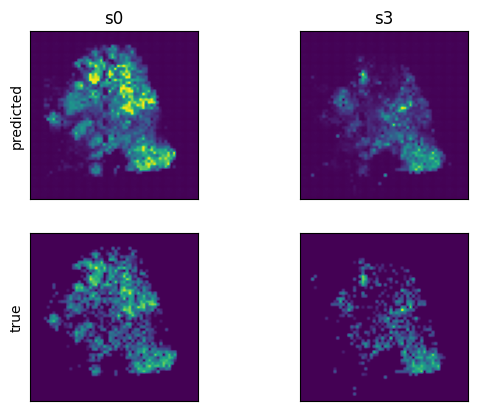

In [20]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

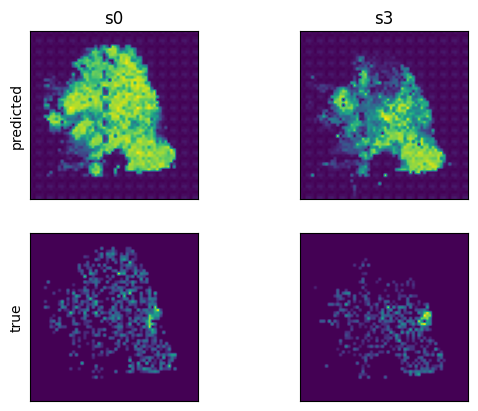

In [23]:
mushroom.display_predicted_pixels(channel='CD68')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

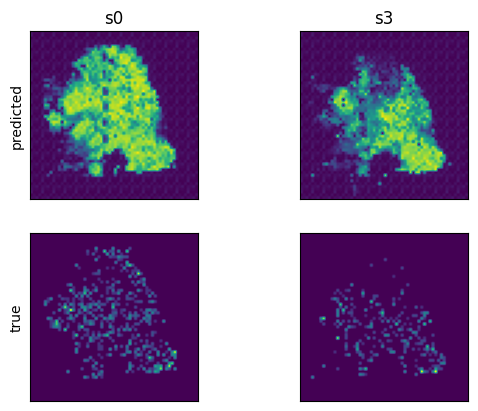

In [31]:
mushroom.display_predicted_pixels(channel='PTPRC')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

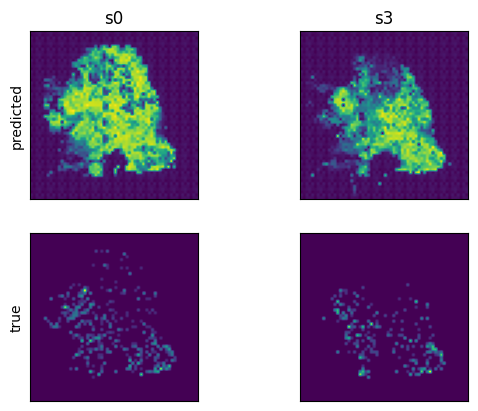

In [34]:
mushroom.display_predicted_pixels(channel='MS4A1')

In [24]:
# mushroom.display_predicted_pixels(channel='pca_2')

In [25]:
mushroom.recon_imgs.shape, mushroom.true_imgs.shape

(torch.Size([2, 11608, 60, 60]), torch.Size([2, 11608, 60, 60]))

In [26]:
mushroom.cluster_sections(margin=10)

INFO:root:no background channel detected, defaulting to mean of all channels
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 13] Permission denied: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/data/estorrs/miniconda3/en

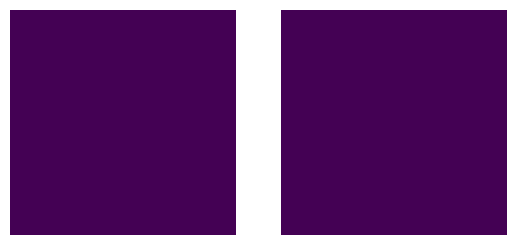

In [27]:
mushroom.clusterer.display_section_masks()

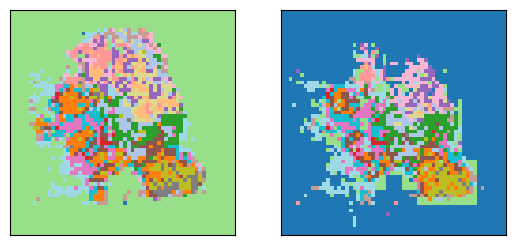

In [28]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

In [29]:
import seaborn as sns
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

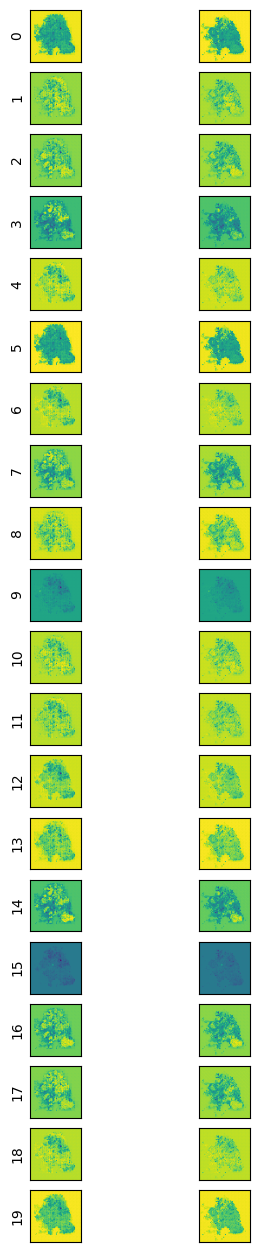

In [30]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

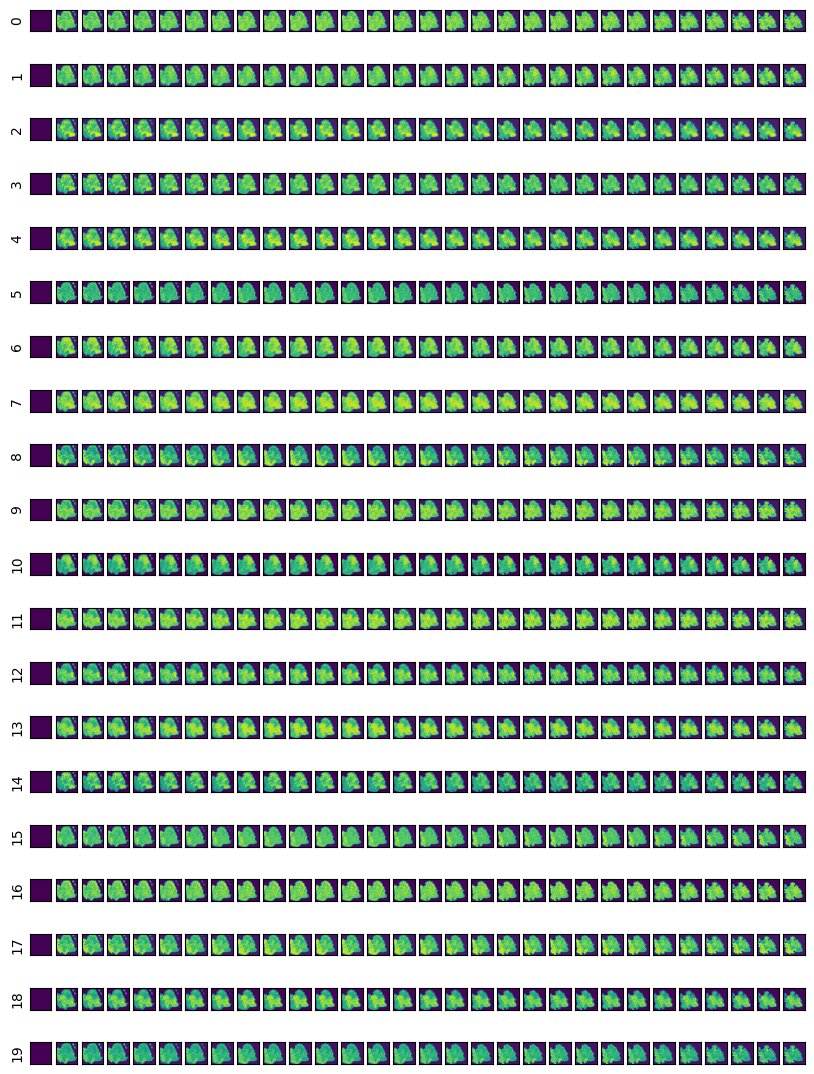

In [33]:
mushroom.clusterer.display_distances(mushroom.dists_volume, figsize=(10, 14))

In [255]:
mushroom.cluster_sections(recluster=False)

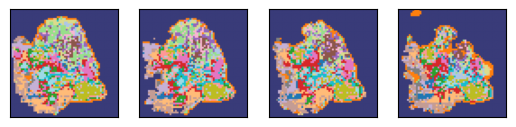

In [256]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

In [36]:
mushroom.save_config(os.path.join(out_dir, 'config.yaml'))

In [37]:
mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [8]:
loaded_mushroom = Mushroom.from_config(os.path.join(out_dir, 'config.yaml'))

INFO:root:using device: cuda
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's2', 's4', 's5']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset


In [289]:
loaded_mushroom.embed_sections()

In [290]:
loaded_mushroom.cluster_sections(recluster=False)

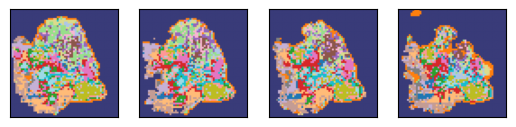

In [292]:
loaded_mushroom.clusterer.display_cluster_ids(loaded_mushroom.cluster_ids)

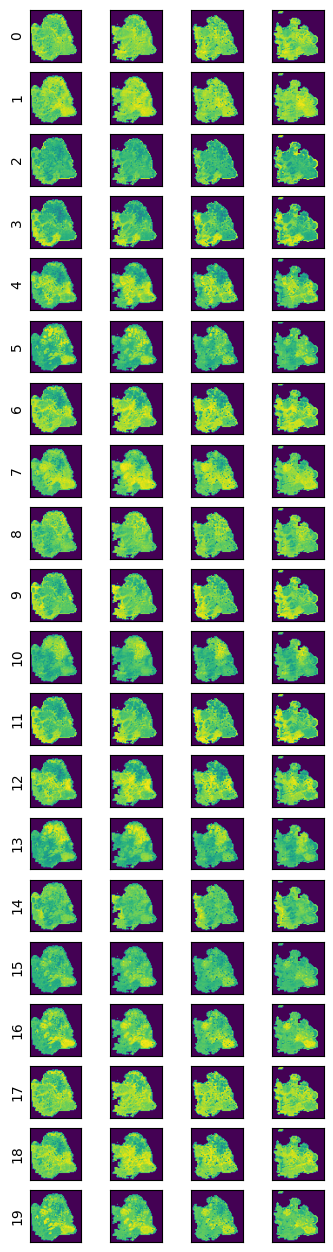

In [293]:
loaded_mushroom.clusterer.display_distances(loaded_mushroom.dists, figsize=(4, 16))

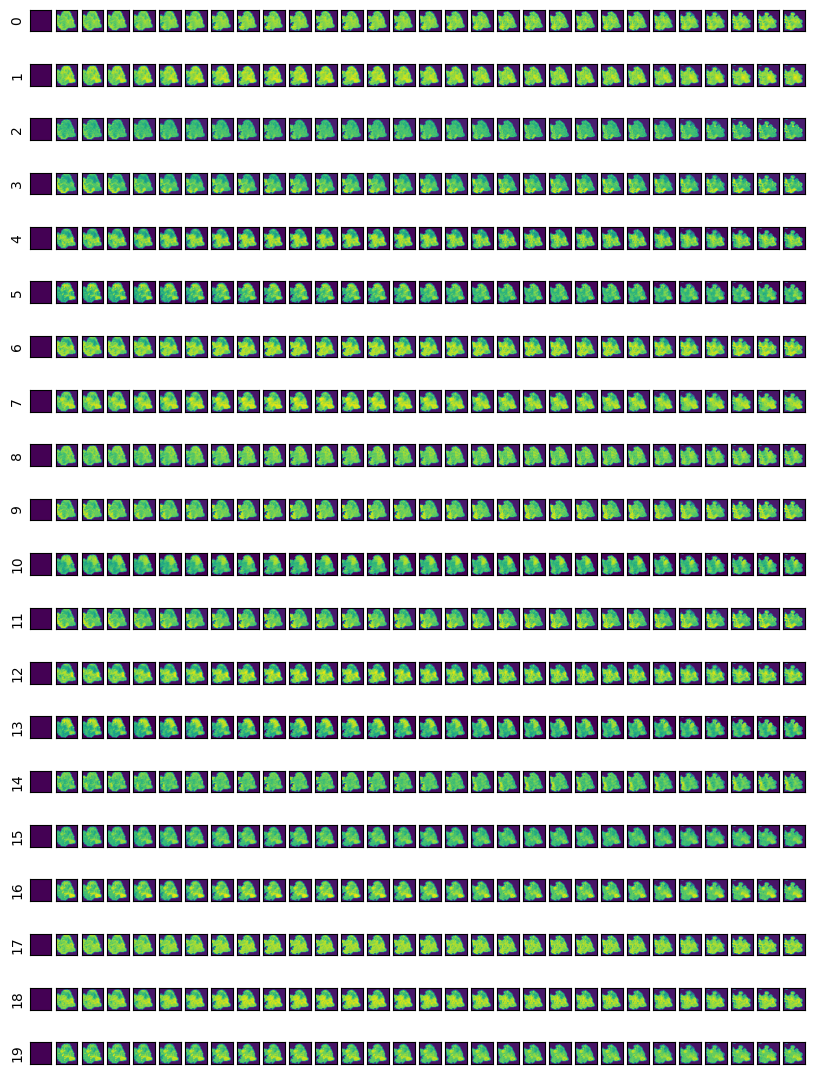

In [294]:
loaded_mushroom.clusterer.display_distances(loaded_mushroom.dists_volume, figsize=(10, 14))

## visium

In [7]:
# channels = [
#     'APOC1',
#     'SBSPON',
#     'COL11A1',
#     'ASPN',
#     'KLHL1',
#     'ACTG2',
#     'KREMEN2',
#     'NPNT',
#     'MMP13',
#     'AQP3',
#     'SLITRK6',
#     'S100P',
#     'CEACAM5',
#     'OLR1',
#     'UBD',
#     'PCDH7',
#     'CYP4Z1',
#     'DKK3',
#     'IGSF6',
#     'THBS4',
#     'MS4A6A',
#     'BMPR1B',
#     'CNIH4',
#     'PSMB9',
#     'GREB1L',
#     'CCNO',
#     'SYT13',
#     'TSPAN1',
#     'IL7R',
#     'AIF1',
#     'GMFG',
#     'MX1',
#     'CHST11',
#     'TNFRSF12A',
#     'GXYLT2',
#     'MMP9',
#     'EGR2',
#     'ACP5',
#     'RAB26',
#     'DTL',
#     'PTDSS2',
#     'DDX58',
#     'PNPLA3',
#     'CDK1',
#     'STC2',
#     'PLEKHO2',
#     'CLEC2B',
#     'SHROOM1',
#     'ITGBL1',
#     'S100A8',
#     'ATAD3C',
#     'MS4A7',
#     'CORO2A',
#     'SAMD12',
#     'DNAAF1',
#     'PEPD',
#     'IFT88',
#     'CCNB1',
#     'IGLC1',
#     'VGLL3',
#     'MAK16',
#     'ZNF117',
#     'STEAP1',
#     'PRR7',
#     'CYFIP2',
#     'CCNG2',
#     'TSPYL5',
#     'FCGR2A',
#     'MB',
#     'FGFR2',
#     'VSIR',
#     'RP1',
#     'LAIR1',
#     'FOSB',
#     'GFRA1',
#     'ERBB4',
#     'NTHL1',
#     'MARVELD3',
#     'EPHA1',
#     'ATAT1',
#     'HSPB8',
#     'C5orf38',
#     'KLF5',
#     'EDRF1',
#     'FAM114A2',
#     'COL7A1',
#     'GSTCD',
#     'KLC4',
#     'SCML1',
#     'TTC13',
#     'CXCL16',
#     'CDK2',
#     'RSPH1',
#     'OGN',
#     'PPME1',
#     'CYP51A1',
#     'RARRES1',
#     'KDM6A',
#     'MUC5B',
#     'TAGAP'
# ]
# channels = [
#     'APOC1',
#     'SBSPON',
# ]

In [6]:
out_dir = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium'
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [7]:
# mushroom_config = {
#     'dtype': 'visium',
#     'sections': section_config,
#     'chkpt_filepath': None,
#     'sae_kwargs': {
#         'size': 256,
#         'patch_size': 32,
# #         'patch_size': 
#         'triplet_scaler': 1.,
#         'recon_scaler': 1.
#     },
#     'learner_kwargs': {
#         'scale': .1,
#         'num_workers': 10,
#         'pct_expression': .02,
# #         'channel_mapping': channel_mapping
#     },
#     'train_kwargs': {
#         'num_iters': 1000,
#         'lr': 1e-4,
#         'log_every': 10,
#         'save_every': 100,
#         'save_dir': chkpt_dir       
#     },
#     'cluster_kwargs': {
#         'num_clusters': 20,
#         'mask_background': True,
#         'margin': .05,
#         'background_channels': None,
#         'span_all_sections': True
#     }
# }

In [8]:
mushroom_config = {
    'dtype': 'visium',
    'sections': section_config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': 1.,
        'recon_scaler': 1.,
    },
    'learner_kwargs': {
        'scale': .1,
        'num_workers': 1,
        'pct_expression': .02,
        'batch_size': 32,
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 500,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 100,
        'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True
    }
}

In [9]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11608 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [10]:
d = mushroom.learner.train_ds[0]
d.keys()

dict_keys(['anchor_idx', 'pos_idx', 'neg_idx', 'anchor_img', 'pos_img', 'neg_img'])

In [11]:
d['anchor_img'].shape

torch.Size([11608, 8, 8])

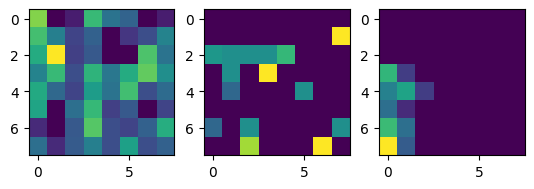

In [12]:
fig, axs = plt.subplots(ncols=3)
idx = mushroom.learner.channels.index('EPCAM')
axs[0].imshow(d['anchor_img'][idx])
axs[1].imshow(d['pos_img'][idx])
axs[2].imshow(d['neg_img'][idx])

In [13]:
# low is ~.2

In [14]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(1.3928, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8852, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(0.7538, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5817, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4103, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 30: {'overall_loss': tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3530, device='cuda:0', grad_fn=<Div

INFO:root:iteration 320: {'overall_loss': tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3736, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 330: {'overall_loss': tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3870, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 340: {'overall_loss': tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3728, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 350: {'overall_loss': tensor(0.3648, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3088, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 360: {'o

In [15]:
mushroom.chkpt_filepath = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium/chkpts/300iter.pt'
mushroom.embed_sections()

In [16]:
mushroom.recon_imgs.shape

torch.Size([2, 11608, 60, 60])

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

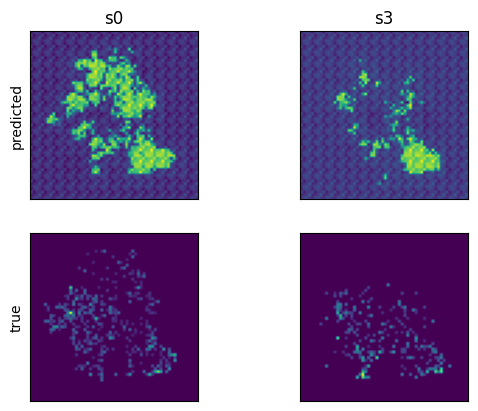

In [17]:
mushroom.display_predicted_pixels(channel='IL7R')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

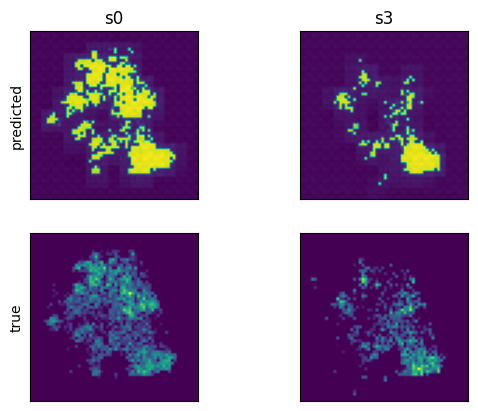

In [18]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

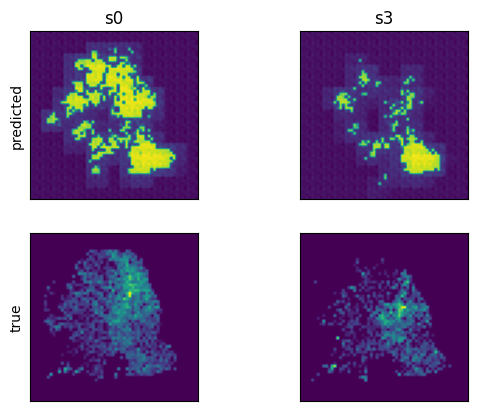

In [19]:
mushroom.display_predicted_pixels(channel='ACTA2')

In [23]:
mushroom.cluster_sections(margin=10.)

INFO:root:no background channel detected, defaulting to mean of all channels


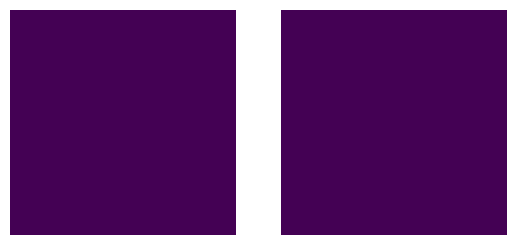

In [24]:
mushroom.clusterer.display_section_masks()

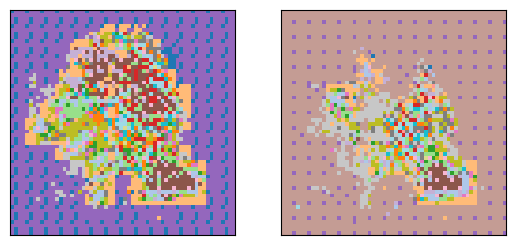

In [25]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

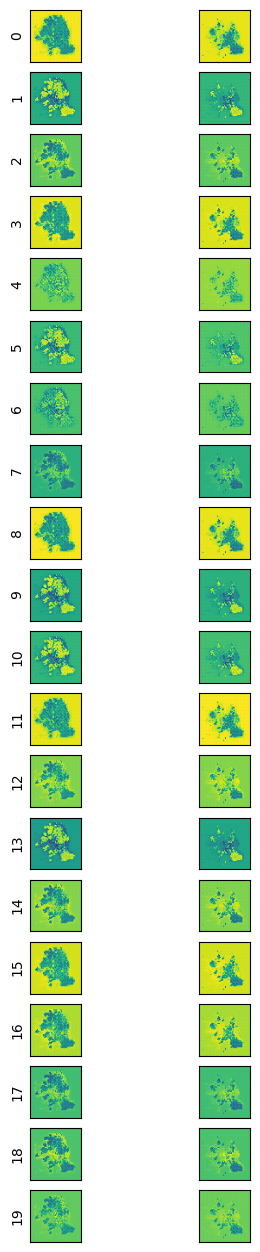

In [26]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

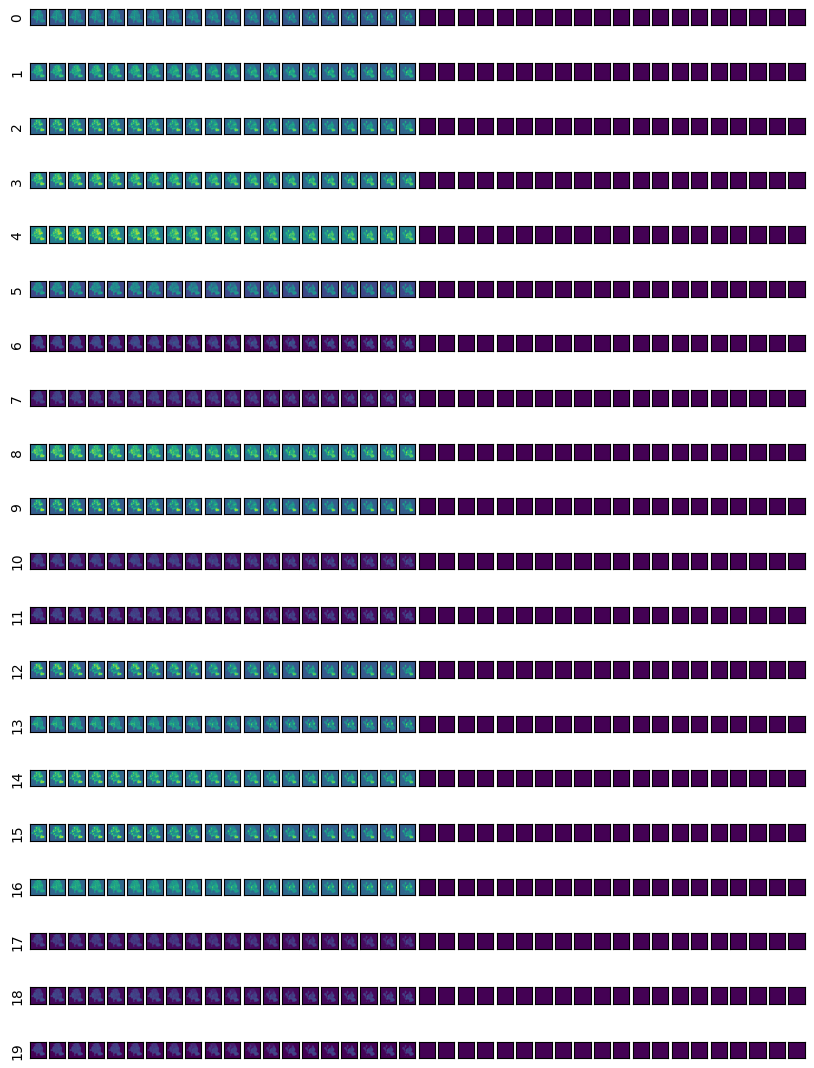

In [174]:
mushroom.clusterer.display_distances(mushroom.dists_volume, figsize=(10, 14))

In [175]:
mushroom.save_config(os.path.join(out_dir, 'config.yaml'))

In [176]:
mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [28]:
import tifffile
orig = tifffile.imread('/data/estorrs/sandbox/mushroom_tmps/s0_exp.ome.tiff')
orig.shape

(11608, 59, 58)

In [29]:
orig.max(), orig.min()

(6.912072, 0.0)

In [33]:
idx = mushroom.learner.channels.index('EPCAM')
idx

3118

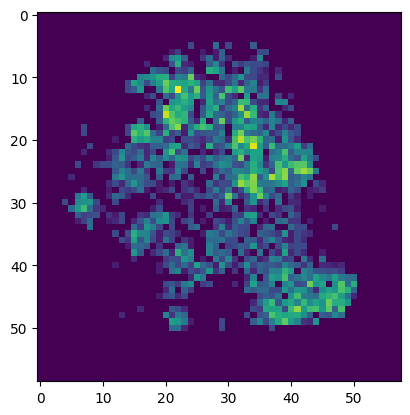

In [34]:
plt.imshow(orig[idx])

In [35]:
x = mushroom.true_imgs[0]
x.shape

torch.Size([11608, 60, 60])

In [36]:
x.max(), x.min()

(tensor(7.6629), tensor(0.))

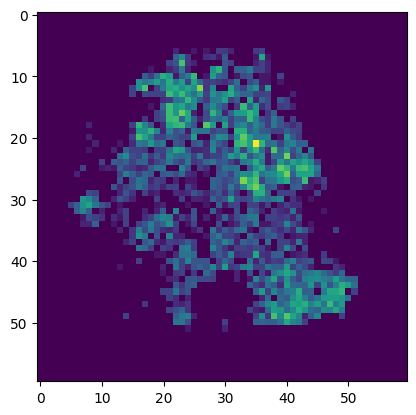

In [37]:
plt.imshow(x[idx])

In [38]:
d = mushroom.learner.train_ds[0]
d.keys()

dict_keys(['anchor_idx', 'pos_idx', 'neg_idx', 'anchor_img', 'pos_img', 'neg_img'])

In [40]:
d['anchor_img'].max(), d['anchor_img'].min()

(tensor(10.7367), tensor(-2.6335))